# Bias correcting daily WRF precipitation using a probabilistic neural network  

### Import required packages 

In [807]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas
import os, shutil, time, pdb, random
import scipy.stats as stats 

from IPython.display import clear_output

from math import pi
from datetime import datetime
from collections import OrderedDict
import pickle

import torch
from torch.utils.data import TensorDataset, DataLoader 

from importlib import reload
from models import *
from utils import *
from runmanager import *
from experiment import *
from plot_utils import *
from preprocessing_utils import *

# from shapely.geometry import box, mapping
import descartes

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rc_file_defaults()
%matplotlib inline

import seaborn as sns
# sns.set_theme()

pd.options.display.max_columns = None

np.random.seed(4)

%load_ext autoreload
%autoreload 2

# Detect device.
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import data

In [810]:
# Parameters
start="1998-01-01"
end="2007-12-31"

TRAIN_PATH = "../data/pickle/df_stations_all_nonzero_extended.pkl"
TEST_PATH = "../data/pickle/df_stations_val_all_nonzero_extended.pkl"

In [811]:
st =     (import_dataframe(TRAIN_PATH)
    .pipe(drop_df_NaNs, series='Prec')
    #.pipe(clip_time_period, start, end)
    )  

st['Year'] = pd.DatetimeIndex(pd.to_datetime(st['Date'], format='%Y-%m-%d')).year
st['month'] = pd.DatetimeIndex(pd.to_datetime(st['Date'], format='%Y-%m-%d')).month
st['season'] = st.apply(season_apply, axis=1) 

st = FilterCompleteStationYears(st)

# st['set'] = "train" 

# st_val = (import_dataframe(TEST_PATH) # Import dataframe
#     .pipe(drop_df_NaNs, series='Prec') # Drop NaNs
#     .pipe(clip_time_period, start, end) # Clip data temporally 
# )

# st_val['set'] = "test"

In [813]:
def sort_by_quantile(st):
    
    QM_data = {}
    list_stations = st['Station'].unique()
    
    for i, s in enumerate(list_stations):
        QM_data[s] = st[st['Station']==s].sort_values(by='wrf_prcp')
        QM_data[s]['Prec'] = QM_data[s]['Prec'].sort_values().values

        if i == 0:
            QM_df = QM_data[s]
        else:
            QM_df = QM_df.append(QM_data[s])

    QM_df.reset_index(drop=True)
    
    return QM_df

In [814]:
sort_by_quantile_flag = False
if sort_by_quantile_flag:
    st = sort_by_quantile(st)

In [815]:
# List bias-corrected and non-bias-corrected stations
bc_stations = list_bc_stations(st)
non_bc_stations = disjunctive_union_lists(st['Station'].unique(), bc_stations)

In [816]:
# Append validation stations to training 
# st = st.append(st_val)

In [817]:
# Filter by basin
# st = st[st['Basin']=='Beas']

In [818]:
# Add observed precipitation value from previous day
st['obs_yesterday'] = st.groupby('Station')['Prec'].shift(1)
st.dropna(inplace=True)

### Split data into held out sets for single model run

We will start by defining the set of stations to be split into training, validation and test held out sets.

In [819]:
# If True, validation and test sets will only include bias corrected stations.
split_bias_corrected_only = True

# Set of stations to be split into training, validation and test held out sets.
if split_bias_corrected_only:
    st_names = list(set(bc_stations) & set(st['Station'].unique()))
else:
    st_names = st['Station'][st['set']=='train'].unique()

# st_names_test = st['Station'][st['set']=='test'].unique()
st_names = np.array(st_names)

In [820]:
# Random selection of locations for train and test
np.random.shuffle(st_names)

split = round(len(st_names) * 0.2)

st_names_dict = {}

non_bc_st_names = non_bc_stations # list(set(list(st['Station'].unique())) - set(list(st_names)))

# st_names_dict['train'] = list(st_names)#[:split*4])
# st_names_dict['val'] = list(st_names_test)#[split*4:])
# st_names_dict['test'] = list(st_names_test)

st_names_dict['train'] = list(st_names[:split*3])    
st_names_dict['val'] = list(st_names[split*3:split*4])
st_names_dict['test'] = list(st_names[split*4:split*5]) 

include_non_bc_stations = True

if include_non_bc_stations:
    st_names_dict['train'] += non_bc_st_names

print("%s stations used for training, %s used for validation, and %s used testing" % (len(st_names_dict['train']), len(st_names_dict['val']), len(st_names_dict['test'])))

44 stations used for training, 6 used for validation, and 6 used testing


In [821]:
# val_stations = ['Pandoh', 'Banjar', 'Bhuntar', 'Larji', 'Sainj', 'Janjehl',
#                 'Hamirpur', 'Nadaun', 'Sujanpur', 'Dehra', 'Kangra', 'Palampur',
#                 'Sadar-Mandi', 'Jogindernagar', 'Sarkaghat']

# train_stations = ['Sundernagar', 'BanjarIMD', 'Bharmaur', 'Churah', 'Kalatop',
#                     'Salooni', 'Rohru', 'Jubbal', 'Kothai', 'Nahan', 'Paonta Sahib',
#                     'Rakuna', 'Pachhad', 'Dadahu', 'Dhaula Kuan', 'Kandaghat', 'Suni',
#                     'Rampur', 'Kasol', 'Bhakra', 'Sadar-Bilarspur', 'Ghumarwin',
#                     'Bhoranj', 'Karsog', 'Theog', 'Kumarsain', 'Mashobra', 'Arki',
#                     'RampurIMD', 'SuniIMD', 'Berthin', 'Bharatgarh', 'Daslehra',
#                     'Ganguwal', 'Ghanauli', 'Kotata', 'Lohard', 'Naina Devi', 'Nangal',
#                     'Olinda', 'Swaghat', 'Kalpa', 'Kaza']

# test_stations = val_stations

# train_stations = non_bc_stations #bc_stations
# val_stations = bc_stations #non_bc_stations
# test_stations = bc_stations #non_bc_stations

# st_names_dict['train'] = train_stations
# st_names_dict['val'] = val_stations
# st_names_dict['test'] = test_stations

# print("%s stations used for training, %s used for validation, and %s used testing" % (len(st_names_dict['train']), len(st_names_dict['val']), len(st_names_dict['test'])))

### Split data into held out sets for K-fold cross validation

In [222]:
include_non_bc_stations = True

split_dict = {}

kf = KFold(n_splits=10,shuffle=True)
#kf.get_n_splits(st_names)

for i, (train_index, test_index) in enumerate(kf.split(st_names)):
    k = round(len(train_index)*0.8)
    split_dict[f'k{i}'] = {f'train': list(st_names[train_index[:k]]) + non_bc_st_names if include_non_bc_stations else list(st_names[train_index[:k]]),
                           f'val' : st_names[train_index[k:]],
                           f'test' : st_names[test_index[:]]
                          }

In [313]:
kf = KFold(n_splits=5, shuffle=True)

years=np.array(range(1998,2008))

split_dict = {}
for i, (train_index, test_index) in enumerate(kf.split(years)):
    k = round(len(train_index)*0.75)
    
    split_dict[f'k{i}'] = {f'train': list(years[train_index[:k]]),
                           f'val' : years[train_index[k:]],
                           f'test' : years[test_index[:]]
                          }

In [314]:
# print("# Split dict:")
# for k,v in split_dict.items():
#     print(" " + k)
#     for kk,vv in v.items():
#         print(f"  {kk} = {len(vv)}")
#         print(vv)

### Prepare data

In [1274]:
data = {}

predictors = [
                'wrf_prcp',
                'wrf_prcp_-2','wrf_prcp_-1','wrf_prcp_1','wrf_prcp_2',
                'Z',
                'doy_sin',
                'doy_cos',
                #'X',
                #'Y',
                'aspect',
                'slope',
                #'obs_yesterday',
                'era5_u','era5_u_-1','era5_u_-2','era5_u_1','era5_u_2',
                'era5_v','era5_v_-1','era5_v_-2','era5_v_1','era5_v_2',
             ]

predictant = ['Prec']

In [1275]:
split_by = 'year'

In [1276]:
X = st[predictors].to_numpy()

x_mean = X.mean(axis=0)
x_std = X.std(axis=0)

for i in range(len(split_dict)):

    if split_by=='station':
       
        data[f'X_train_{i}'] = (st[st['Station'].isin(split_dict[f'k{i}']['train'])][predictors].to_numpy() - x_mean) / x_std
        data[f'X_val_{i}'] = (st[st['Station'].isin(split_dict[f'k{i}']['val'])][predictors].to_numpy() - x_mean) / x_std
        data[f'X_test_{i}'] = (st[st['Station'].isin(split_dict[f'k{i}']['test'])][predictors].to_numpy() - x_mean) / x_std

        data[f'Y_train_{i}'] = st[st['Station'].isin(split_dict[f'k{i}']['train'])][predictant].to_numpy()
        data[f'Y_val_{i}'] = st[st['Station'].isin(split_dict[f'k{i}']['val'])][predictant].to_numpy()
        data[f'Y_test_{i}'] = st[st['Station'].isin(split_dict[f'k{i}']['test'])][predictant].to_numpy()
    
    elif split_by=='year':
    
        data[f'X_train_{i}'] = (st[st['Year'].isin(split_dict[f'k{i}']['train'])][predictors].to_numpy() - x_mean) / x_std
        data[f'X_val_{i}'] = (st[st['Year'].isin(split_dict[f'k{i}']['val'])][predictors].to_numpy() - x_mean) / x_std
        data[f'X_test_{i}'] = (st[st['Year'].isin(split_dict[f'k{i}']['test'])][predictors].to_numpy() - x_mean) / x_std

        data[f'Y_train_{i}'] = st[st['Year'].isin(split_dict[f'k{i}']['train'])][predictant].to_numpy()
        data[f'Y_val_{i}'] = st[st['Year'].isin(split_dict[f'k{i}']['val'])][predictant].to_numpy()
        data[f'Y_test_{i}'] = st[st['Year'].isin(split_dict[f'k{i}']['test'])][predictant].to_numpy()
    

# data['X_test'] = (st[st['Station'].isin(st_names_dict['test'])][predictors].to_numpy() - x_mean) / x_std
# data['Y_test'] = st[st['Station'].isin(st_names_dict['test'])][predictant].to_numpy()

# data['X_test2'] = (st_val[predictors].to_numpy() - x_mean) / x_std
# data['Y_test2'] = st_val[predictant].to_numpy()

### Train model with single run

In [1277]:
def create_dataset(data, split, d):
    tensor_x = torch.Tensor(data[f'X_{split}'][:,:d])
    tensor_y = torch.Tensor(data[f'Y_{split}'][:,:d])
    return TensorDataset(tensor_x, tensor_y)

In [1278]:
years_dict = {}
years_dict['train'] = list(range(1998,2008))
years_dict['val'] = disjunctive_union_lists(list(st['Year'].unique()),list(range(1998,2008)))[:10] #list(range(2004,2006))
years_dict['test'] = disjunctive_union_lists(list(st['Year'].unique()),list(range(1998,2008)))[10:] #list(range(2006,2008))

In [1279]:
d = len(predictors) # define number of input dimensions

splits = ['train', 'val', 'test']

# years = range(1998,2005)

for i in splits:
        
    #data[f'X_{i}'] = (st[st['Station'].isin(st_names_dict[f'{i}'])][predictors].to_numpy() - x_mean) / x_std
    #data[f'Y_{i}'] = st[st['Station'].isin(st_names_dict[f'{i}'])][predictant].to_numpy()
    
    data[f'X_{i}'] = (st[st['Year'].isin(years_dict[f'{i}'])][predictors].to_numpy() - x_mean) / x_std
    data[f'Y_{i}'] = st[st['Year'].isin(years_dict[f'{i}'])][predictant].to_numpy()
    
train_dataset = create_dataset(data=data,split='train',d=d)
val_dataset = create_dataset(data=data,split='val',d=d)
test_dataset = create_dataset(data=data,split='test',d=d)
    
# train_tensor_x = torch.Tensor(data['X_train'][:,:d]) # transform to torch tensor
# train_tensor_y = torch.Tensor(data['Y_train'][:,:d])
# train_dataset = TensorDataset(train_tensor_x,train_tensor_y) # create your dataset

# val_tensor_x = torch.Tensor(data['X_val'][:,:d]) # transform to torch tensor
# val_tensor_y = torch.Tensor(data['Y_val'][:,:d])
# val_dataset = TensorDataset(val_tensor_x,val_tensor_y) # create your dataset

# test_tensor_x = torch.Tensor(data['X_test'][:,:d]) # transform to torch tensor
# test_tensor_y = torch.Tensor(data['Y_test'][:,:d])
# test_dataset = TensorDataset(test_tensor_x,test_tensor_y) # create your dataset

# test2_tensor_x = torch.Tensor(data['X_test2'][:,:d]) # transform to torch tensor
# test2_tensor_y = torch.Tensor(data['Y_test2'][:,:d])
# test2_dataset = TensorDataset(test2_tensor_x,test2_tensor_y) # create your dataset

In [1280]:
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False)

In [1281]:
model = MLP(in_channels=d, 
            hidden_channels=[50], 
            likelihood_fn='bgmm', # 'gaussian', gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
            dropout_rate=0,
            linear_model=False
           )

print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 1203


In [1282]:
experiment_name = f'MLP_{model.likelihood}'
wd = WorkingDirectory(generate_root(experiment_name))

# Save model parameters
arg_list = ['in_channels','hidden_channels','likelihood','dropout_rate','linear_model']
model_args = {}

for k in arg_list:
    model_args[k] = getattr(model, k)

with open(os.path.join(wd.root,'model_args.pickle'), 'wb') as handle:
    pickle.dump(model_args, handle, protocol=pickle.HIGHEST_PROTOCOL)

train_losses = []
val_losses = []
test_losses = []

epochs = 30

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):

    train_loss, val_loss, test_loss = train_epoch(model, optimizer, train_loader, valid_loader, test_loader=test_loader, print_progress=True, epoch=epoch)
    
    # wandb.log({"train_loss":train_loss, "val_loss":val_loss, "test_loss":test_loss})
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    save_as_best = True if val_loss == min(val_losses) else False
    save_checkpoint(wd,model.state_dict(),is_best=save_as_best)
    
    PATH = os.path.join(wd.root,'e_%s_loss_%.3f.pth.tar' % (epoch, val_loss))
    torch.save(model.state_dict(), PATH)

BEST_PATH = os.path.join(wd.root,'model_best.pth.tar')
model.load_state_dict(torch.load(BEST_PATH))

Root: _experiments/2021-08-06_18-26-07_mlp-bgmm
epoch : 1, train loss : 1.3078, valid loss : 1.1733
epoch : 2, train loss : 1.1341, valid loss : 1.1494
epoch : 3, train loss : 1.1207, valid loss : 1.1399
epoch : 4, train loss : 1.1147, valid loss : 1.1387
epoch : 5, train loss : 1.1111, valid loss : 1.1329
epoch : 6, train loss : 1.1087, valid loss : 1.1328
epoch : 7, train loss : 1.1061, valid loss : 1.1344
epoch : 8, train loss : 1.1049, valid loss : 1.1336
epoch : 9, train loss : 1.1028, valid loss : 1.1326
epoch : 10, train loss : 1.1019, valid loss : 1.1301
epoch : 11, train loss : 1.1004, valid loss : 1.1316
epoch : 12, train loss : 1.0994, valid loss : 1.1313
epoch : 13, train loss : 1.0985, valid loss : 1.1313
epoch : 14, train loss : 1.0978, valid loss : 1.1288
epoch : 15, train loss : 1.0970, valid loss : 1.1337
epoch : 16, train loss : 1.0964, valid loss : 1.1272
epoch : 17, train loss : 1.0957, valid loss : 1.1295
epoch : 18, train loss : 1.0954, valid loss : 1.1325
epoch :

<All keys matched successfully>

In [1283]:
LOAD_CHECKPOINT = False
LOAD_MODELBEST = True

if LOAD_CHECKPOINT and LOAD_MODELBEST:
    print("\n Both LOAD_CHECKPOINT and LOAD_MODELBEST flags are set to True. \n PLEASE SET ONLY ONE TO TRUE")

elif LOAD_CHECKPOINT:
    CHECKPOINT_PATH = os.path.join(wd.root,'checkpoint.pth.tar')
    model.load_state_dict(torch.load(CHECKPOINT_PATH))

elif LOAD_MODELBEST:
    MODELBEST_PATH = os.path.join(wd.root,'model_best.pth.tar')
    model.load_state_dict(torch.load(MODELBEST_PATH))

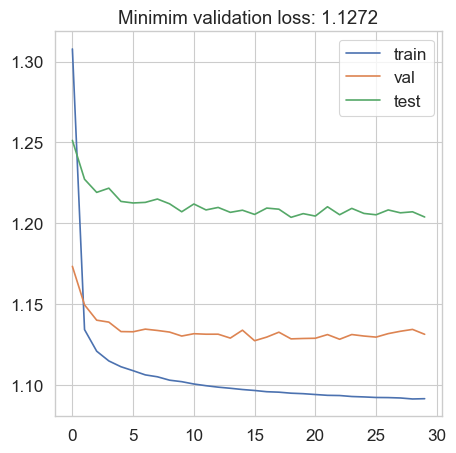

In [1284]:
# sns.set_theme()
# with sns.plotting_context("talk", rc={"lines.linewidth": 2}):
plt.figure(figsize=(5,5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(test_losses)
plt.legend(["train","val","test"])
plt.title(f"Minimim validation loss: {min(val_losses):.4f}")
plt.show()

In [1285]:
# PATH = '../../PhD/data/pickle/df_map1.pkl'
# test_map = pd.read_pickle(PATH)

# data['X_map'] = (test_map[predictors].to_numpy() - x_mean) / x_std

# model.eval()

# with torch.no_grad():
#     map_inputs = torch.Tensor(data['X_map'][:,:d])
#     map_outputs = model(map_inputs)

In [1286]:
# %%time
# map_results = build_results_df(test_map,
#                        outputs=map_outputs,
#                        st_names_test=None,
#                        model=model,
#                        p=0.05,
#                        confidence_intervals=True,
#                        calculate_errors=False)

In [1287]:
# from scipy.interpolate import griddata

# xRange = np.sort(map_results['X'].unique())
# yRange = np.sort(map_results['Y'].unique())
# points = list(zip(map_results.X,map_results.Y))
# values = map_results['wrf_prcp'].values

# #create arrays of x,y over the raster extension
# gridX,gridY = np.meshgrid(xRange,yRange)

# #interpolate over the grid
# gridValues = griddata(points, values, (gridX,gridY), method='linear')

# #show interpolated values
# plt.imshow(gridValues)
# plt.gca().invert_yaxis()
# plt.xticks([]), plt.yticks([])
# plt.show()

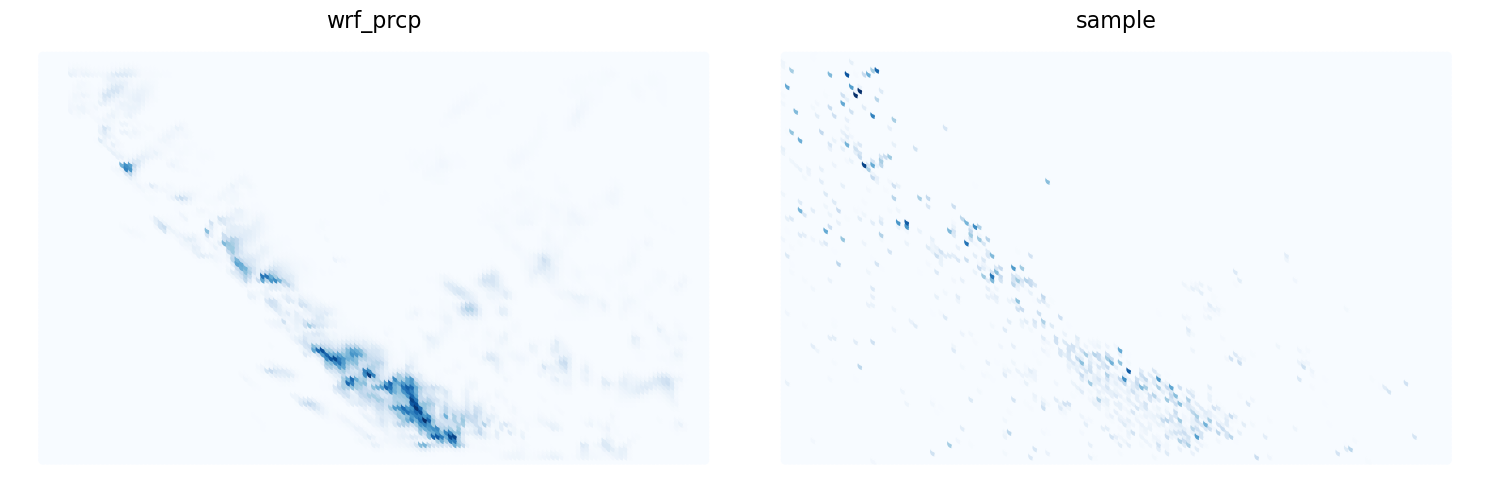

In [248]:
n = 2
fig, axes = plt.subplots(1,n,figsize=(n*5 + 5, 5))
cols = ['wrf_prcp','sample','high_ci','low_ci','Z']

map_results = build_results_df(test_map,
                           outputs=map_outputs,
                           st_names_test=None,
                           model=model,
                           p=0.05,
                           confidence_intervals=True,
                           calculate_errors=False)

for index, ax in enumerate(axes.flatten()):
    
    if index < len(cols):
        col = cols[index]
    else:
        col = cols[-1]
    
    ax.scatter(x=map_results['X'], y=map_results['Y'], c=map_results[col], cmap="Blues")
    ax.set_title(col, fontsize=16)
    ax.set_xticklabels([]), ax.set_yticklabels([])
    ax.set_frame_on(False)
    ax.set_xticks([]), ax.set_yticks([])

plt.tight_layout()
plt.show()

In [1307]:
model.eval()

with torch.no_grad():
    
    test_inputs = test_dataset.tensors[0]
    test_outputs = model(test_inputs)

#     test2_inputs = test2_dataset.tensors[0]
#     test2_outputs = model(test2_inputs)

### Histograms of predicted parameter values 

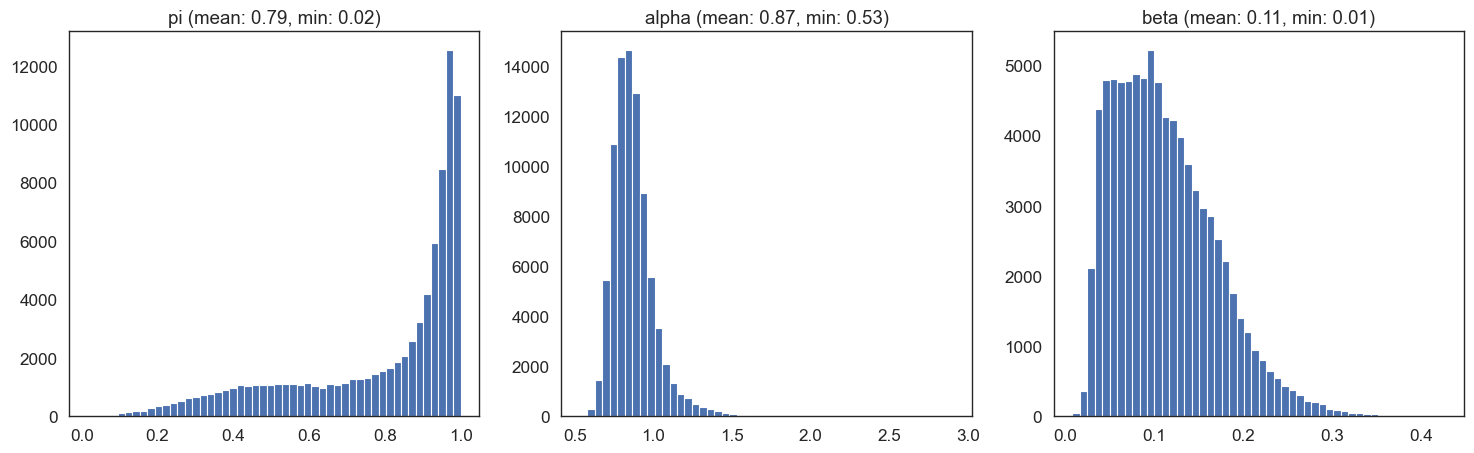

In [1308]:
sns.set_theme(context='paper',style='white',font_scale=1.4)
plot_parameter_histograms(model, test_outputs)

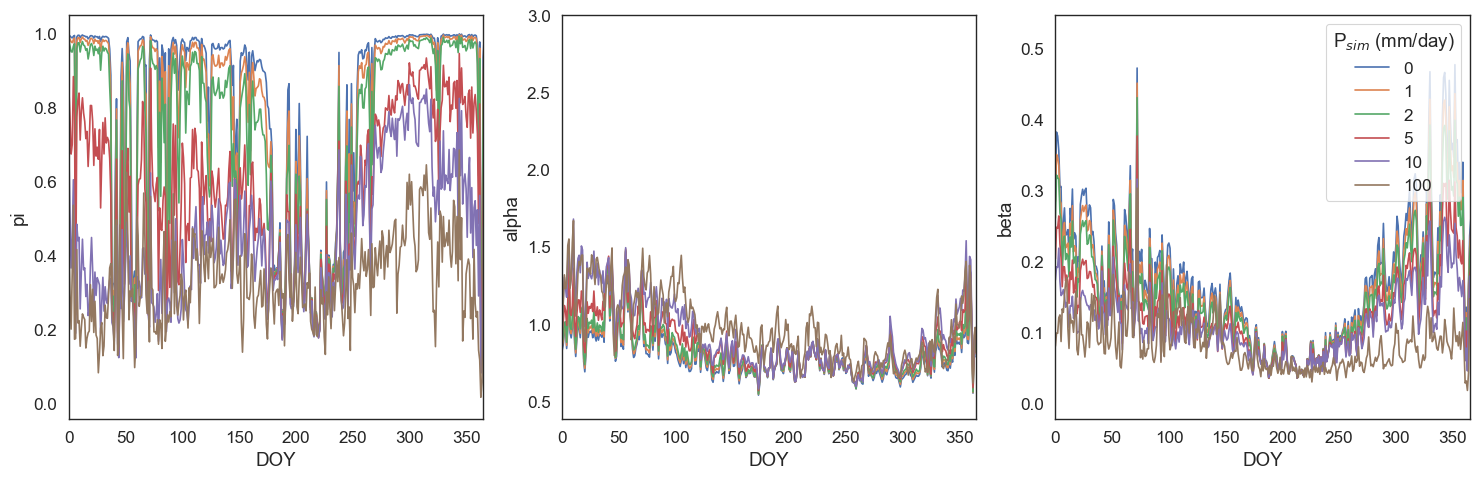

In [1290]:
# %%capture

sns.set_theme(context='paper',style='white',font_scale=1.4)

title_labels = ['pi', 'alpha', 'beta'] 

fig, axes = plt.subplots(1,3, figsize=(15,5))

for idx, ax in enumerate(axes.flatten()):
    for i in [0,1,2,5,10,100]:
        zero_wrf = test_dataset.tensors[0][:,0].mode()[0] 
        test_inputs = test_dataset.tensors[0].clone()
        test_inputs[:,0:1] = zero_wrf + (i-x_mean[0])/x_std[0]
        model.eval()
        with torch.no_grad():
            test_outputs = model(test_inputs)
        ax.plot(test_outputs[:,idx],label=i)
    if idx==2:
        ax.legend(title="P$_{sim}$ (mm/day)", loc="upper right")
    ax.set_xlim(0,365)
    #ax.set_title(title_labels[idx])
    ax.set_xlabel("DOY")
    ax.set_ylabel(title_labels[idx])
        
plt.tight_layout()
plt.show()

In [1291]:
def plot_bgmm_params_annual_timeseries(st_test, station='Pandoh', start_time='2003-01-01', end_time='2003-12-31'):

    """ Creates a figure with 3 subplots plotting annual evolution of the BGMM parameters"""

    df = st_test[st_test['Station']==station]
    df = clip_time_period(df, start_time, end_time)

    fig,[ax1,ax2] = plt.subplots(2,1,figsize=(15,10))
    ax1.plot(df['pi'],label='pi')
    ax1.plot(df['alpha'],label='alpha')
    ax1.plot(df['beta'],label='beta')
    ax1.legend()
    ax2.plot(df['wrf_prcp'],label='wrf')
    ax2.plot(df['Prec'],label='obs')
    ax2.legend()
    plt.tight_layout()
    plt.show()

In [1292]:
%%capture

# sns.set_theme()
# list_of_stations = ['Berthin','Daslehra']
# # fig, axes = plt.subplots(1,2,figsize=(10,5))
# # for idx, ax in enumerate(axes.flatten()):
# #     s = list_of_stations[idx]
# #     df = st_test[st_test['Station']==s]
# #     y = df['sample']-df['Prec']
# #     ax.scatter(x=df['Prec'],y=y,label=s)
# #     ax.legend()

# df = clip_time_period(st_test,'2000-01-01','2005-01-31')
# df = df[df['Station'].isin(list_of_stations)]
# df['residuals'] = df['sample'] - df['Prec']
# #df.groupby(['Station'])['wrf_prcp'].first().unstack()#.unstack()
# df = df.pivot(index='Date',
#         columns='Station',
#         values='residuals')

# df.dropna(inplace=True)
# # df1 = df[df['Station']=='Sainj']
# # y1 = df1['wrf_prcp']-df1['Prec']
# # df2 = df[df['Station']=='Larji']
# # y2 = df2['wrf_prcp']-df2['Prec']
# plt.scatter(df[list_of_stations[0]],df[list_of_stations[1]])
# plt.show()

# np.corrcoef(df[list_of_stations[0]],df[list_of_stations[1]])

### Plot sample distribution

In [1293]:
# plot_sample_distribution(model, outputs, test_dataset, force_non_zero=True)

### Summary of results

In [1303]:
n_samples = 1

In [1368]:
%%time
st_test = build_results_df(st[(st['Year'].isin(years_dict['test']))],
                           outputs=test_outputs,
                           st_names_test=None, #st_names_dict['test'],
                           model=model,
                           p=0.05,
                           confidence_intervals=False,
                           calculate_errors=False,
                           draw_samples=True,
                           n_samples=n_samples)

CPU times: user 8.87 s, sys: 121 ms, total: 8.99 s
Wall time: 8.99 s


In [1369]:
st_test = st_test[st_test['Station'].isin(st_names)].copy()

In [1311]:
# %%time
# st_test = build_results_df(st,
#                            outputs=test_outputs,
#                            st_names_test=st_names_dict['test'],
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True,
#                            calculate_errors=True,
#                            n_samples=3)

In [1312]:
# list_wet_days_mlp = []

# for i in range(10):
    
#     df = build_results_df(st,
#                            outputs=test_outputs,
#                            st_names_test=st_names_dict['test'],
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True)

#     wet_days_mlp = (df['sample']!=0).sum()
#     # print(i, wet_days_mlp)

#     list_wet_days_mlp.append(wet_days_mlp)
    
# wet_days_reg = (df['wrf_bc_prcp']!=0).sum()
# wet_days_obs = (df['Prec']!=0).sum()

In [1313]:
# plt.plot(list_wet_days_mlp,'o')
# plt.plot([0,9],[np.mean(list_wet_days_mlp),np.mean(list_wet_days_mlp)])
# plt.plot([wet_days_obs]*10)
# plt.plot([wet_days_reg]*10)
# plt.show()

In [1314]:
# np.mean(list_wet_days_mlp/wet_days_obs) , np.std(list_wet_days_mlp/wet_days_obs)

# print(f"Ratio of predicted vs actual wet days (BC): {wet_days_reg / wet_days_obs:.4f}")
# print(f"Ratio of predicted vs actual wet days (MLP): {np.mean(list_wet_days_mlp/wet_days_obs):.4f}")

In [1315]:
# st_test = build_results_df(st_val,
#                            outputs=test2_outputs,
#                            st_names_test=st_val['Station'].unique(),
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True)

In [1316]:
st_test = predictions['bgmm']['k_all']

In [861]:
# st_test = st_test[st_test['Station'].isin(st_names)].copy()

In [1370]:
almost_dry = 0

#print(f"Ratio of predicted vs actual dry days (BC): {(st_test['wrf_bc_prcp']==0).sum() / (st_test['Prec']==0).sum():.4f}")

# for i in range(n_samples):
#     print(f"Ratio of predicted vs actual dry days (MLP) {i}: {(st_test[f'sample_{i}']==0).sum() / (st_test['Prec']==0).sum():.4f}")

# print(f"Ratio of predicted vs actual dry** days (BC): {(st_test['wrf_bc_prcp']<=almost_dry).sum() / (st_test['Prec']<=almost_dry).sum():.4f}")
# print(f"Ratio of predicted vs actual dry** days (MLP): {(st_test['sample']<=almost_dry).sum() / (st_test['Prec']<=almost_dry).sum():.4f}")

print(f"Ratio of predicted vs actual wet days (BC): {(st_test['wrf_bc_prcp']>almost_dry).sum() / (st_test['Prec']>almost_dry).sum():.4f}")

for i in range(n_samples):
    print(f"Ratio of predicted vs actual wet days (MLP) {i}: {(st_test[f'sample_{i}']>almost_dry).sum() / (st_test['Prec']>almost_dry).sum():.4f}")

# print(f"Ratio of predicted vs actual wet days (MLP): {(st_test['sample_0']!=0).sum() / (st_test['Prec']!=0).sum():.4f}")

# print(f"Ratio of predicted vs actual wet** days (BC): {(st_test['wrf_bc_prcp']>almost_dry).sum() / (st_test['Prec']>almost_dry).sum():.4f}")
# print(f"Ratio of predicted vs actual dry** days (MLP): {(st_test['sample']>almost_dry).sum() / (st_test['Prec']>almost_dry).sum():.4f}")

# tail_high = (st_test['sample']>st_test['high_ci']).sum()
# tail_low = (st_test['sample']<st_test['low_ci']).sum()

# print(f"Percentage of outliers at 95% confidence: {(tail_high + tail_low) / len(st_test):.4f}")

Ratio of predicted vs actual wet days (BC): 1.0803
Ratio of predicted vs actual wet days (MLP) 0: 0.8894


In [ ]:
st_test_nontruncated = st_test.copy()

In [1335]:
def truncate_sample(x, threshold=50):
    if x>threshold:
        return threshold
    else:
        return x
    
for i in range(n_samples):
    st_test[f'sample_{i}'] = st_test[f'sample_{i}'].apply(lambda x: truncate_sample(x))

In [1336]:
st_test = pairwise_errors(st_test)

In [1337]:
st_test.columns

Index(['Date', 'Station', 'Prec', 'Corrected Station Name', 'X', 'Y',
       'Altitude (m)', 'Z', 'wrf_prcp', 'wrf_bc_prcp', 'elev_hr', 'aspect',
       'slope', 'doy', 'doy_sin', 'doy_cos', 'wrf_prcp_-1', 'wrf_prcp_-2',
       'wrf_prcp_1', 'wrf_prcp_2', 'Basin', 'lon', 'lat', 'era5_u', 'era5_v',
       'era5_u_-2', 'era5_u_-1', 'era5_u_1', 'era5_u_2', 'era5_v_-2',
       'era5_v_-1', 'era5_v_1', 'era5_v_2', 'Year', 'month', 'season',
       'BC_diff', 'obs_yesterday', 'pi', 'alpha', 'beta', 'occurrence', 'mean',
       'perc_median', 'median', 'uniform_0', 'sample_0', 'se_wrf', 'se_bcp',
       'se_mlp_mean', 'se_mlp_median', 'e_wrf', 'e_bcp', 'se_mlp_sample_0',
       'e_mlp_sample_0'],
      dtype='object')

In [1338]:
pairwise_mse = st_test.groupby(['Station']).mean()[['se_wrf','se_bcp']+[f'se_mlp_sample_{i}' for i in range(n_samples)]].reset_index()

# fig, ax = plt.subplots(figsize=(25,5))

# sns.barplot(data=pairwise_mse.melt(id_vars='Station'),x='Station',y='value',hue='variable', ax=ax)
# plt.show()

In [1339]:
pairwise_mse.mean()

se_wrf             144.999581
se_bcp             134.986995
se_mlp_sample_0    122.651257
dtype: float64

### Plot squared errors

In [1371]:
sample_cols = [f'sample_{i}' for i in range(n_samples)]

columns = ['Prec','wrf_prcp','wrf_bc_prcp'] + sample_cols #,'mean','median']
labels = ['Obs', 'WRF', 'Bias corrected WRF','Sample (MLP)']
seasons = st['season'].unique()#['DJF','MAM','JJA','SON']
basins = ['Sutlej','Beas']

# if model.likelihood != 'gumbel':
#     pass
#     #columns.append('median')
#     #labels.append('Median (MLP)')
# if model.likelihood in ['b2gmm','bgmm']:
#     pass
#     #columns.append('median_gamma')
#     #labels.append('Median Gamma (MLP)')

In [1372]:
#st_test['sample']=st_test['sample_1'].astype('float64').copy()

In [1373]:
len(st_test['Station'].unique())

14

## Seasonal predictions

In [1374]:
# st_test = st_test[st_test['median']>200]

### Analsys of results (per season per year)

In [1375]:
def count_zeros(x):
    return np.sum(x==0)

In [1376]:
df = st_test.groupby(['Station','season','Year']).sum()[columns].copy()

df_dry_days = st_test.groupby(['Station','season','Year'], as_index=False)[columns]
df_dry_days = df_dry_days.agg([count_zeros]).droplevel(level=1, axis=1)

for i in range(n_samples):
    df_dry_days[f'edd_mlp_{i}'] = abs(df_dry_days[f'sample_{i}'] - df_dry_days['Prec'])
    
df_dry_days['edd_mlp'] = df_dry_days[[f'edd_mlp_{i}' for i in range(n_samples)]].mean(axis=1)

df_dry_days['edd_bc'] = abs(df_dry_days['wrf_bc_prcp'] - df_dry_days['Prec'])

df['se_wrf'] = (df['wrf_prcp'] - df['Prec'])**2
df['se_bc_wrf'] = (df['wrf_bc_prcp'] - df['Prec'])**2

df['sample'] = df[sample_cols].mean(axis=1)

for i in range(n_samples):
    df[f'se_mlp_{i}'] = (df[f'sample_{i}'] - df['Prec'])**2
    
df['se_mlp'] = df[[f'se_mlp_{i}' for i in range(n_samples)]].mean(axis=1)

df['e_wrf'] = (df['wrf_prcp'] - df['Prec'])
df['e_bc_wrf'] = (df['wrf_bc_prcp'] - df['Prec'])  
    
df['ae_wrf'] = abs(df['wrf_prcp'] - df['Prec'])
df['ae_bc_wrf'] = abs(df['wrf_bc_prcp'] - df['Prec'])

for i in range(n_samples):
    df[f'e_mlp_{i}'] = (df[f'sample_{i}'] - df['Prec'])
    df[f'ae_mlp_{i}'] = abs(df[f'sample_{i}'] - df['Prec'])
    
df['e_mlp'] = df[[f'e_mlp_{i}' for i in range(n_samples)]].mean(axis=1)    
df['ae_mlp'] = df[[f'ae_mlp_{i}' for i in range(n_samples)]].mean(axis=1)

df['aer_mlp'] = df['ae_wrf'] - df['ae_mlp']
df['aer_bc_wrf'] = df['ae_wrf'] - df['ae_bc_wrf']

df['imp_bc_wrf'] = 1 - df['se_bc_wrf']/(df['se_wrf'])
df['imp_mlp'] = 1 - df['se_mlp']/(df['se_wrf'])

df_dry_days = df_dry_days[['edd_mlp','edd_bc']]

df['smape_wrf'] = df['ae_wrf'] / (df['Prec']+df['wrf_prcp'])
df['smape_bc_wrf'] = df['ae_bc_wrf'] / (df['Prec']+df['wrf_bc_prcp'])
df['smape_mlp'] = df['ae_mlp'] / (df['Prec']+df['sample'])

df = pd.merge(df,df_dry_days,on=['Station','season','Year'])

In [1377]:
e = df.reset_index().melt(id_vars=['Station','season','Year'],
                      value_vars=['e_wrf','e_bc_wrf','e_mlp']#,'imp_bc_wrf','imp_mlp','se_wrf','se_bc_wrf','se_mlp','edd_mlp','edd_bc'],
                     )

# MAE
ae = df.reset_index().melt(id_vars=['Station','season','Year'],
                      value_vars=['ae_wrf','ae_bc_wrf','ae_mlp']#,'imp_bc_wrf','imp_mlp','se_wrf','se_bc_wrf','se_mlp','edd_mlp','edd_bc'],
                     )

# MAE REDUCTION
aer = df.reset_index().melt(id_vars=['Station','season','Year'],
                      value_vars=['aer_bc_wrf','aer_mlp'],
                     )
# ERROR IN DRY DAYS 
edds = df.reset_index().melt(id_vars=['Station','season','Year'],
                      value_vars=['edd_bc','edd_mlp'],
                     )

# MSE IMPROVEMENT RATIO                    
improvement = df.reset_index().melt(id_vars=['Station','season','Year'],
                      value_vars=['imp_bc_wrf','imp_mlp'],
                     )
# SMAPE
smape = df.reset_index().melt(id_vars=['Station','season','Year'],
                      value_vars=['smape_wrf','smape_bc_wrf','smape_mlp'] 
                     )

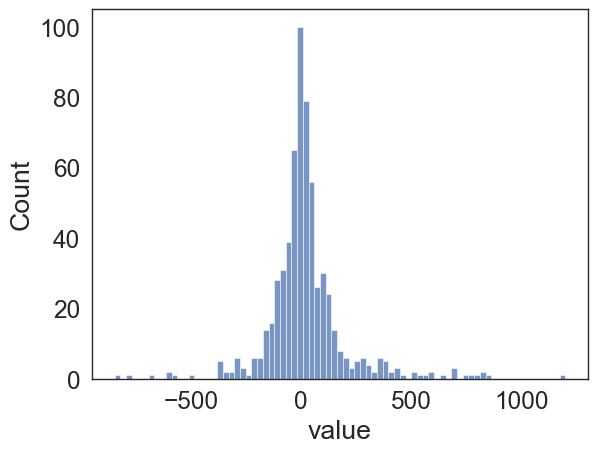

In [1379]:
sns.histplot(data=e[e['variable']=='e_mlp'], x='value')
plt.show()

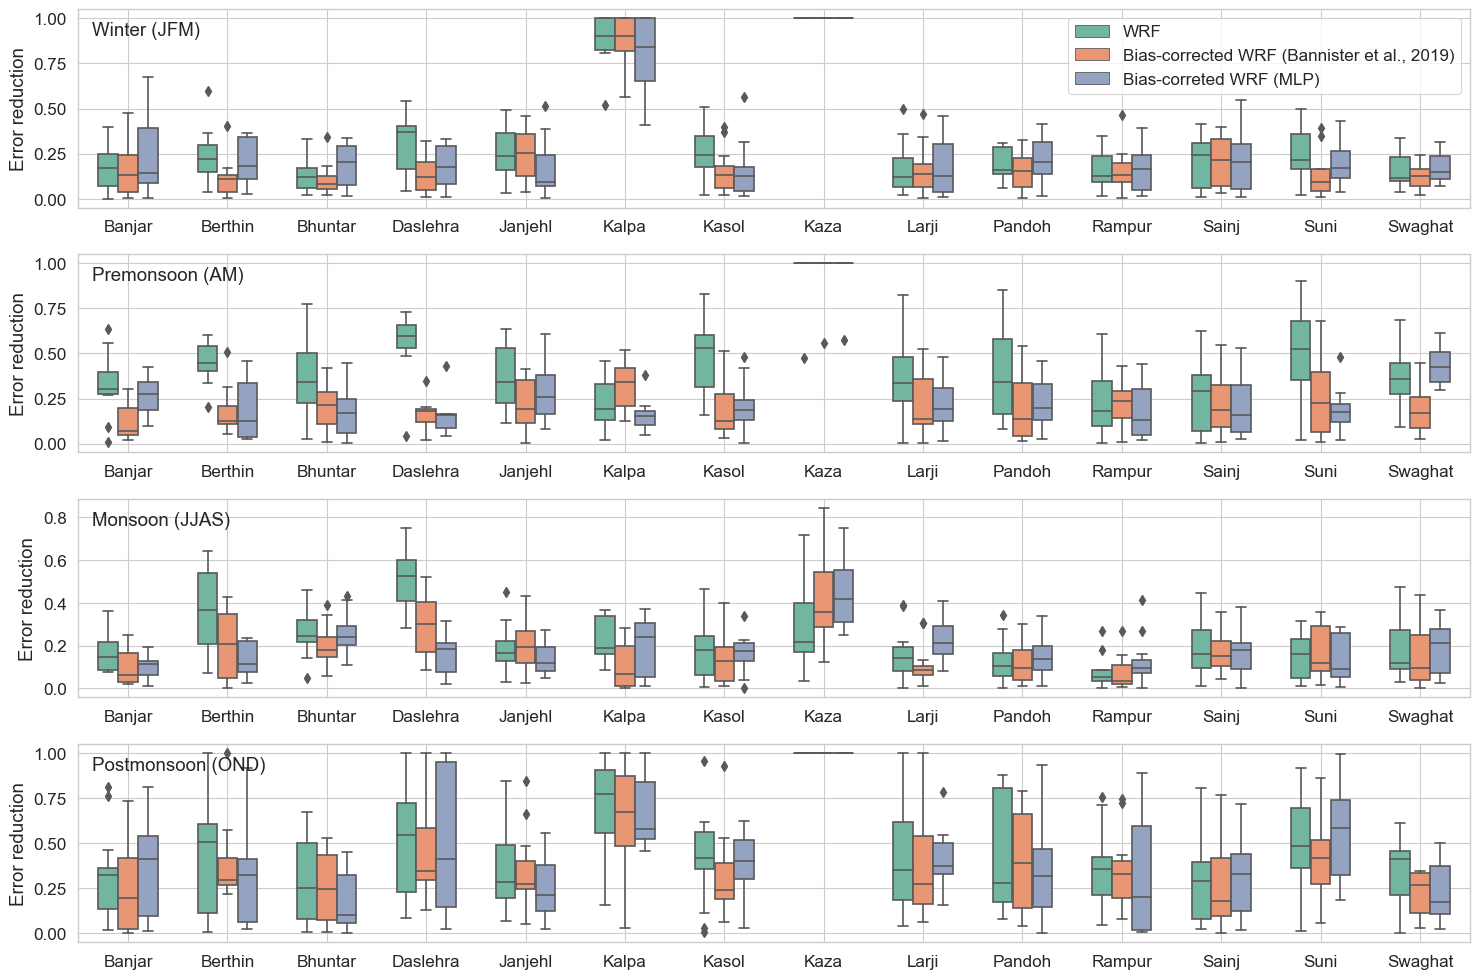

In [1347]:
sns.set_theme(context='paper',style='whitegrid',font_scale=1.4)

fig, axes = plt.subplots(4,1,figsize=(15,10))

plot_data = smape
yaxis_label = 'Error reduction'

for i, ax in enumerate(axes.flatten()):

    season = seasons[i]

    sns.boxplot(data=plot_data[plot_data['season']==season]
                ,x='Station'
                ,y='value'
                ,hue='variable'
                ,ax=ax
                ,palette='Set2'
                ,width=0.6)

    #ax.set_xticklabels([]) if i < 3 else ax.set_xticklabels(means.index.values, rotation=45, horizontalalignment='right')
    ax.set_xlabel(None)
    ax.set_ylabel(yaxis_label)
    
#     ax.set_title(f"{season} | MSE improvement ratio | baseline = {imp_bc_wrf:.2f} | NN = {imp_mlp:.2f}")
#     ax.set_title(f"{season}")
    
    ax.text(0.01, 0.87, f'{season}', fontweight="normal", transform=ax.transAxes)


#                 MAE | WRF = {mae_wrf:.2f} | baseline = {mae_bc_wrf:.2f} | NN = {mae_mlp:.2f}") \n\
#                 RMSE | WRF = {rmse_wrf:.2f} | baseline = {rmse_bc_wrf:.2f} | NN = {rmse_mlp:.2f} \n\
#                 ErrorDryDays | WRF = {edd_bc:.2f} | baseline = {edd_bc:.2f} | NN = {edd_mlp:.2f}
#    ")
    
    
    if i==0:
        leg = ax.get_legend()
        leg.set_title('')
        new_labels = ['Bias-corrected WRF (Bannister et al., 2019)','Bias-correted WRF (MLP)']
        new_labels = ['WRF','Bias-corrected WRF (Bannister et al., 2019)','Bias-correted WRF (MLP)']
        for t, l in zip(leg.texts, new_labels): t.set_text(l)
    else:
        ax.get_legend().remove() if i>0 else None
    
    ax.grid(True)
    
plt.tight_layout()
plt.show()

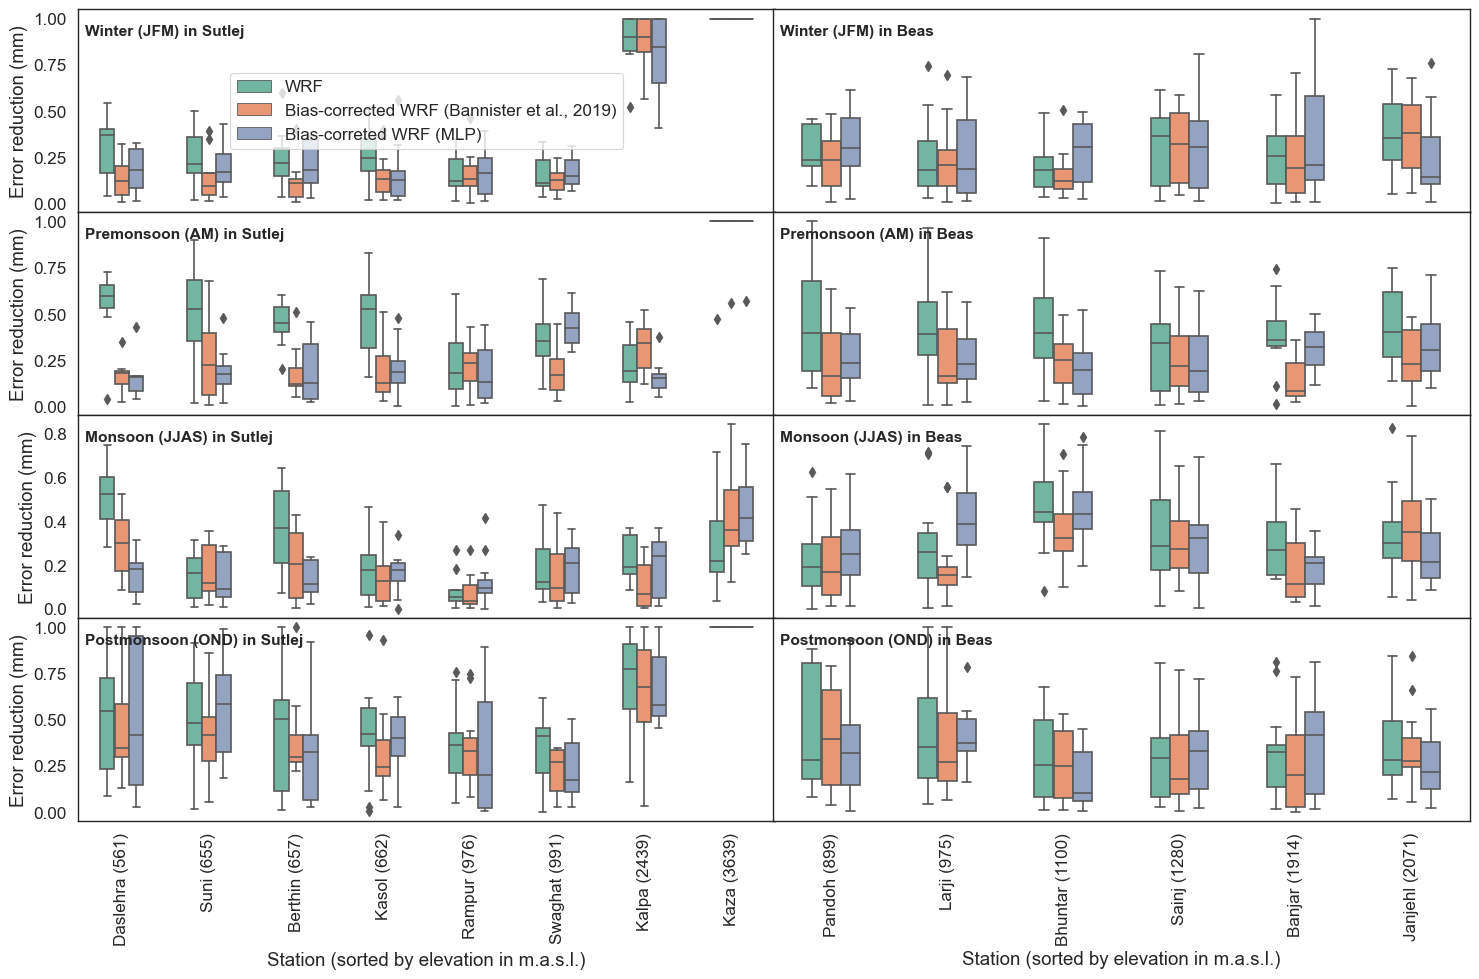

In [1348]:
data1 = smape.copy()

sns.set_theme(context='paper',style='white',font_scale=1.4)

new_labels = ['WRF', 'Bias-corrected WRF (Bannister et al., 2019)','Bias-correted WRF (MLP)']
#new_labels = ['Bias-corrected WRF (Bannister et al., 2019)','Bias-correted WRF (MLP)']
yaxislabel = 'Error reduction (mm)'

fig, axes = plt.subplots(4,2,figsize=(15,10))

for i, season in enumerate(seasons):
    
    data2 = data1[data1['season']==season].copy()
    
    for j, basin in enumerate(basins):
        
        ax = axes[i, j]

        st_basin = st_test[st_test['Basin']==basin]

        sorted_stations = st_basin.groupby(['Station']).mean().sort_values('Z').reset_index()['Station'].unique()
        sorted_elevations = [int(a) for a in st_basin.groupby(['Station']).mean().sort_values('Z').reset_index()['Z'].unique()]

        sorted_labels = [f'{b} ({a})' for a,b in zip(sorted_elevations,sorted_stations)]

        data3 = data2[data2['Station'].isin(sorted_stations)].copy()
        data3['value'] = abs(data3['value']).copy()

        sns.boxplot(data=data3, x='Station',y='value',hue='variable', ax=ax, order=sorted_stations, width=0.5, palette='Set2')

        if i == 0:
            pass #ax.set_title(basin)
        if i == 3:
            ax.set_xlabel('Station (sorted by elevation in m.a.s.l.)')
            ax.set_xticklabels(sorted_labels,rotation=90, horizontalalignment='center')
        else:
            ax.set_xlabel(None)
            ax.set_xticklabels([])
            
        if j == 0:
            ax.set_ylabel(yaxislabel)
            pass #ax.set_ylabel(f'{season}')
        else:
            ax.set_yticklabels([])
            ax.set_ylabel(None)
        
        ax.text(0.01, 0.87, f'{season} in {basin}', fontweight="bold", transform=ax.transAxes, size='small')
        
        # ax.set_ylim(-400,400)
        # plt.ylabel('Correlation factor')
        # plt.xlabel('Lag (days)')
        
        if (i == j == 0):
            ax.legend(loc='center')
            leg = ax.get_legend()
            leg.set_title('')
            for t, l in zip(leg.texts, new_labels): t.set_text(l)
        else:
            ax.get_legend().remove()

plt.tight_layout(h_pad=-0.1, w_pad=-0.1)
plt.savefig('figures/seasonal-plots.png',dpi=300)
plt.show()

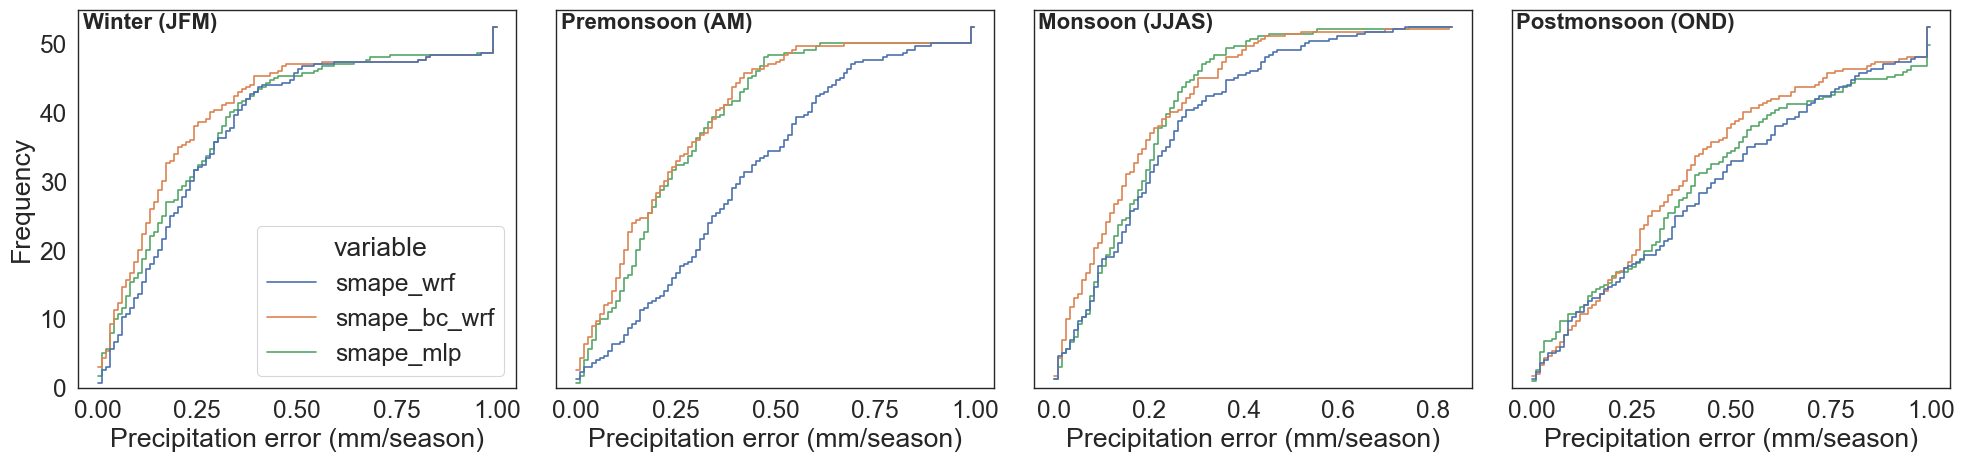

In [1349]:
sns.set_theme(context='paper',style='white',font_scale=2)
plot_data = smape
fig, axes = plt.subplots(1,4,figsize=(20,5))
for index, ax in enumerate(axes.flatten()):
    season = seasons[index]
    sns.histplot(data=plot_data[plot_data['season']==season],x='value',hue='variable', 
                 bins=100, multiple='layer', element='step', stat='frequency',
                 cumulative=True, fill=False, shrink=0.8, ax=ax)
    ax.text(0.01, 0.95, f'{season}', fontweight="demibold", transform=ax.transAxes, size='small')
    ax.get_legend().remove() if index>0 else None
    ax.set_yticklabels([]) if index>0 else None
    ax.set_ylabel('') if index>0 else None
    ax.set_xlabel('Precipitation error (mm/season)')
    
plt.tight_layout()
plt.show()

### Seasonal over the entire period

In [1350]:
st_test_season_totals = st_test.groupby(['Station','season']).sum()
st_test_annual_totals = st_test.groupby(['Station']).sum()

In [1351]:
# sns.set_theme(context='paper',style='white',font_scale=1.4)

# fig, axes = plt.subplots(5,1, figsize=(15,10))

# for i, ax in enumerate(axes.flatten()):

#     if i < 4: 

#         season = seasons[i]
#         df = st_test_season_totals[np.in1d(st_test_season_totals.index.get_level_values(1), [season])].copy()
#         df = df.reset_index().set_index('Station')

#     else: 
#         df = st_test_annual_totals
#         season = "Annual"

#     legend = True if i==0 else None
#     df[list(columns[l] for l in [0,1,2,3])].plot.bar(rot=45,ax=ax,legend=legend)

#     df['se_wrf'] = (df['wrf_prcp'] - df['Prec'])**2
#     df['se_bc_wrf'] = (df['wrf_bc_prcp'] - df['Prec'])**2
#     df['se_mlp'] = (df['sample'] - df['Prec'])**2

#     df['se_imp_bc_wrf'] = df['se_bc_wrf'] - df['se_wrf']
#     df['se_imp_mlp'] = df['se_mlp'] - df['se_wrf']
    
#     df['imp_bc_wrf'] = 1 - df['se_bc_wrf']/df['se_wrf']
#     df['imp_mlp'] = 1 - df['se_mlp']/df['se_wrf']

# #     ax.set_title("{0} \n\
# #                 MSE improvement ratio | median baseline : {1:.2f} | median NN : {2:.2f} | mean baseline : {3:.2f} | mean NN : {4:.2f} \n \
# #                 MSE improvement | median baseline : {5:.2f} | median NN : {6:.2f} | mean baseline : {7:.2f} | mean NN : {8:.2f} \n"
# #         .format(season,
# #                 df['imp_bc_wrf'].median(),
# #                 df['imp_mlp'].median(),
# #                 df['imp_bc_wrf'].mean(),
# #                 df['imp_mlp'].mean(),
# #                 df['se_imp_bc_wrf'].median(),
# #                 df['se_imp_mlp'].median(),
# #                 df['se_imp_bc_wrf'].mean(),
# #                 df['se_imp_mlp'].mean()
# #                )
# #         )

#     ax.set_title(f"{season}")

#     ax.set_xlabel(None)
#     ax.set_ylabel('Precipitation (mm)')
#     ax.set_xticklabels([]) if i < 4 else None

# plt.tight_layout()

### Seasonal totals 

In [1352]:
for season in seasons:
    
#     df = st_test_season_totals[np.in1d(st_test_season_totals.index.get_level_values(1), [season])].copy()

#     df['se_wrf'] = (df['wrf_prcp'] - df['Prec'])**2
#     df['se_bc_wrf'] = (df['wrf_bc_prcp'] - df['Prec'])**2
#     df['se_mlp'] = (df['sample'] - df['Prec'])**2
    
#     df['rse_bc_wrf'] = df['se_bc_wrf']/df['se_wrf']
#     df['rse_mlp'] = df['se_mlp']/df['se_wrf']
 
#     df['imp_bc_wrf'] = 1 - df['se_bc_wrf']/df['se_wrf']
#     df['imp_mlp'] = 1 - df['se_mlp']/df['se_wrf']

    #print(f"{season} ¦ WRF: {df['se_wrf'].mean():.2f} ¦ WRF BC: {df['se_bc_wrf'].mean():.2f} ¦ MLP: {df['se_mlp'].mean():.2f}")
    
    #print(f"{season} | Mean MSE Imp \t| WRF BC: {df['imp_bc_wrf'].mean():.2f} \t| MLP: {df['imp_mlp'].mean():.2f}")
    #print(f"{season} | Med MSE Imp \t| WRF BC: {df['imp_bc_wrf'].median():.2f} \t| MLP: {df['imp_mlp'].median():.2f}")
    
    #print(f"{season} | Mean MSE Imp \t| WRF BC: {1 - df['se_bc_wrf'].mean()/df['se_wrf'].mean():.2f} \t| MLP: {1 - df['se_mlp'].mean()/df['se_wrf'].mean():.2f}")
    
    df33 = smape[smape['season']==season]
    prefix = 'smape'

    print(f"{season} | Min {prefix} \t| WRF BC: {df33[df33['variable']==f'{prefix}_bc_wrf']['value'].min():.2f} \t| MLP: {df33[df33['variable']==f'{prefix}_mlp']['value'].min():.2f}")
    print(f"{season} | Mean {prefix} \t| WRF BC: {df33[df33['variable']==f'{prefix}_bc_wrf']['value'].mean():.2f} \t| MLP: {df33[df33['variable']==f'{prefix}_mlp']['value'].mean():.2f}")
    print(f"{season} | Median {prefix} \t| WRF BC: {df33[df33['variable']==f'{prefix}_bc_wrf']['value'].median():.2f} \t| MLP: {df33[df33['variable']==f'{prefix}_mlp']['value'].median():.2f}")

Winter (JFM) | Min smape 	| WRF BC: 0.00 	| MLP: 0.00
Winter (JFM) | Mean smape 	| WRF BC: 0.24 	| MLP: 0.26
Winter (JFM) | Median smape 	| WRF BC: 0.14 	| MLP: 0.18
Premonsoon (AM) | Min smape 	| WRF BC: 0.00 	| MLP: 0.00
Premonsoon (AM) | Mean smape 	| WRF BC: 0.25 	| MLP: 0.26
Premonsoon (AM) | Median smape 	| WRF BC: 0.20 	| MLP: 0.20
Monsoon (JJAS) | Min smape 	| WRF BC: 0.00 	| MLP: 0.00
Monsoon (JJAS) | Mean smape 	| WRF BC: 0.17 	| MLP: 0.18
Monsoon (JJAS) | Median smape 	| WRF BC: 0.13 	| MLP: 0.17
Postmonsoon (OND) | Min smape 	| WRF BC: 0.00 	| MLP: 0.00
Postmonsoon (OND) | Mean smape 	| WRF BC: 0.39 	| MLP: 0.39
Postmonsoon (OND) | Median smape 	| WRF BC: 0.33 	| MLP: 0.35


### Annual totals

In [1353]:
st_test_annual_totals['se_wrf'] = (st_test_annual_totals['wrf_prcp'] - st_test_annual_totals['Prec'])**2
st_test_annual_totals['se_bc_wrf'] = (st_test_annual_totals['wrf_bc_prcp'] - st_test_annual_totals['Prec'])**2
st_test_annual_totals['se_mlp'] = (st_test_annual_totals['sample'] - st_test_annual_totals['Prec'])**2

st_test_annual_totals['imp_bc_wrf'] = 1 - st_test_annual_totals['se_bc_wrf']/st_test_annual_totals['se_wrf']
st_test_annual_totals['imp_mlp'] = 1 - st_test_annual_totals['se_mlp']/st_test_annual_totals['se_wrf']

print(f"MSE ¦ WRF: {st_test_annual_totals['se_wrf'].mean():.2f} ¦ WRF BC: {st_test_annual_totals['se_bc_wrf'].mean():.2f} ¦ MLP: {st_test_annual_totals['se_mlp'].mean():.2f}")
print(f"MSE Improvement ratio ¦ WRF BC: {1 - st_test_annual_totals['se_bc_wrf'].mean()/st_test_annual_totals['se_wrf'].mean():.2f} ¦ MLP: {1 - st_test_annual_totals['se_mlp'].mean()/st_test_annual_totals['se_wrf'].mean():.2f}")

KeyError: 'sample'

In [663]:
%%capture
import scipy
print("=========== KS scores ============")
for season in seasons:
    print(f"--- {season} ---")
    for col in columns[1:]:
        rvs = st_test[st_test['season']==season]['Prec']
        cdf = st_test[st_test['season']==season][col]
        #kstest = scipy.stats.kstest(rvs, cdf, args=(), N=20, alternative='two-sided', mode='auto')
        kstest = scipy.stats.ks_2samp(rvs, cdf, alternative='two-sided', mode='auto')
        print(f"{col} : {kstest.statistic:.4f}")

['SuniIMD']


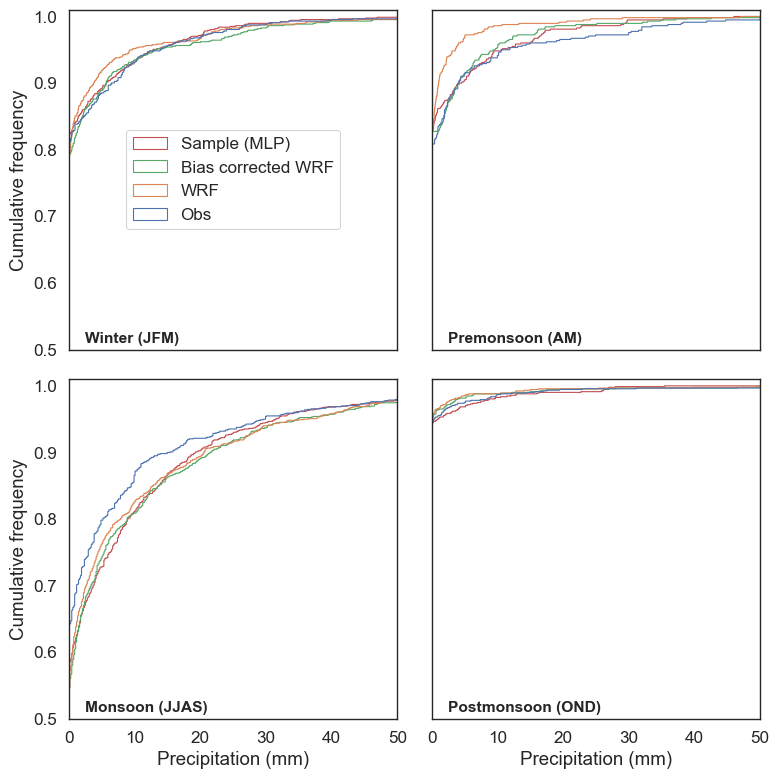

In [734]:
sns.set_theme(context='paper',style='white',font_scale=1.4)

x_hist = st_test[st_test['season']=='DJF'][columns].to_numpy()
n_bins = 1000

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

stations = st_test['Station'].unique()
random_station = np.random.randint(len(stations))
st_test_station = st_test[st_test['Station']==stations[random_station]]
print(st_test_station['Station'].unique())

for idx, ax in enumerate(axes.flatten()):

    x_hist = st_test_station[st_test_station['season']==seasons[idx]][columns].to_numpy()
    ax.hist(x_hist, n_bins, density=True, cumulative=True, histtype='step', label=labels)
    
    ax.set_ylim([0.5,1.01]) 
    ax.set_xlim([0,50])
    ax.set_xlabel('Precipitation (mm)') if idx>1 else None
    ax.set_ylabel('Cumulative frequency') if idx%2==0 else None
    ax.set_xticklabels([]) if not(idx>1) else None
    ax.set_yticklabels([]) if not(idx%2==0) else None
    
    ax.text(0.05, 0.02, f'{seasons[idx]}', fontweight="bold", transform=ax.transAxes, size='small')
    
    if idx==0:
        ax.legend(loc='center')

plt.tight_layout()
plt.show()

In [735]:
print(f"=========== KS scores for {stations[random_station]} station ============")
for season in seasons:
    print(f"--- {season} ---")
    for col in columns[1:]:
        rvs = st_test_station[st_test_station['season']==season]['Prec']
        cdf = st_test_station[st_test_station['season']==season][col]
        #kstest = scipy.stats.kstest(rvs, cdf, args=(), N=20, alternative='two-sided', mode='auto')
        kstest = scipy.stats.ks_2samp(rvs, cdf, alternative='two-sided', mode='auto')
        print(f"{col} : {kstest.statistic:.4f}")

=========== KS scores for SuniIMD station ============
--- Winter (JFM) ---
wrf_prcp : 0.0390
wrf_bc_prcp : 0.0264
sample : 0.0172
--- Premonsoon (AM) ---
wrf_prcp : 0.0793
wrf_bc_prcp : 0.0241
sample : 0.0379
--- Monsoon (JJAS) ---
wrf_prcp : 0.0967
wrf_bc_prcp : 0.0959
sample : 0.0770
--- Postmonsoon (OND) ---
wrf_prcp : 0.0141
wrf_bc_prcp : 0.0109
sample : 0.0098


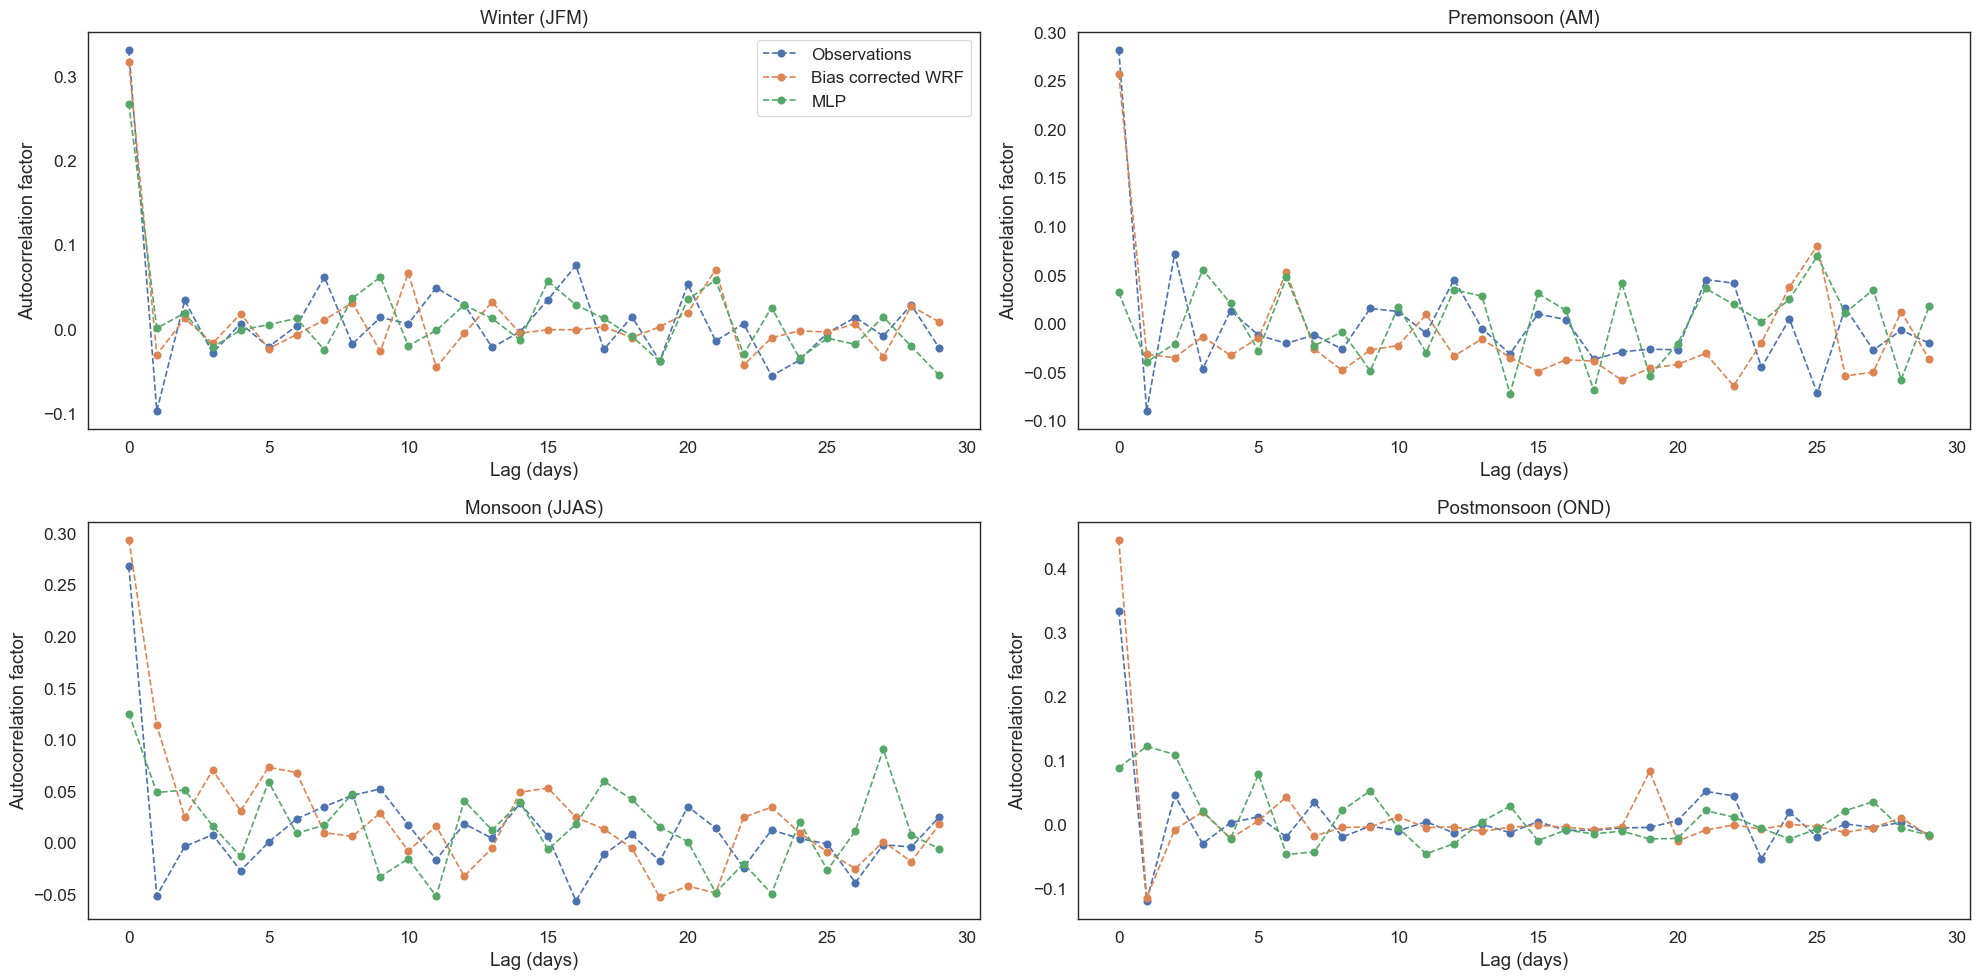

In [737]:
acf_dict = {}
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

fig, axes = plt.subplots(2, 2, figsize=(20,10))

for index, ax in enumerate(axes.flatten()):

    for col in list(np.array(columns)[[0,2,3]]):
        
        x = st_test_station[st_test_station['season']==seasons[index]][col]
        
        if seasons[index] not in acf_dict:
            acf_dict[seasons[index]] = {}
            
        y = acf_dict[seasons[index]][col] = sm.tsa.pacf(x,nlags=30)
        
        ax.plot(y[1:], 'o--', label="col")
        
#         plot_pacf(x,
#                 ax=ax,
#                 use_vlines=False,
#                 alpha=1,
#                 zero=False,
#                 title=seasons[index])
        
    ax.set_xlabel("Lag (days)")
    ax.set_ylabel("Autocorrelation factor")
    ax.set_title(seasons[index])

    if index==0:
        pass
        ax.legend(["Observations","Bias corrected WRF","MLP"])
        #ax.legend(columns[0:3])

#plt.suptitle(f"Autocorrelation factors by season (test station: {st_test_station['Station'].unique()}) ")

plt.tight_layout()
plt.show()

In [738]:
for season in seasons:
    print(f'--- {season} ---')
    for col in list(np.array(columns)[[2,3]]):
        p = acf_dict[season]['Prec']
        q = acf_dict[season][col]
        #kl_divergence(p,q)
        rmse = np.mean((p - q)**2)
        max_diff = np.max(abs(p-q))
        print(f'{col} : {max_diff:.3f}') 

--- Winter (JFM) ---
wrf_bc_prcp : 0.094
sample : 0.098
--- Premonsoon (AM) ---
wrf_bc_prcp : 0.152
sample : 0.250
--- Monsoon (JJAS) ---
wrf_bc_prcp : 0.165
sample : 0.143
--- Postmonsoon (OND) ---
wrf_bc_prcp : 0.111
sample : 0.246


## Multi-Run: Train model with different hyperparameters

In [530]:
params = OrderedDict(
    lr = [0.005]
    ,batch_size = [128]
    ,likelihood_fn = ['bgmm']
    ,hidden_channels = [[10]]#,[50],[100]]
    ,dropout_rate = [0]
    #,k = [0]
    ,k = list(range(5))
)

epochs = 10

In [531]:
m = RunManager()
predictions={}

for l in params['likelihood_fn']:
    predictions[l] = {} 

for run in RunBuilder.get_runs(params):
    
    #d=6
    d = len(predictors)
    
    network = MLP(in_channels=d, 
            hidden_channels=run.hidden_channels, 
            likelihood_fn=run.likelihood_fn,
            dropout_rate=run.dropout_rate,
            )
    
    train_tensor_x = torch.Tensor(data[f'X_train_{run.k}'][:,:d]) # transform to torch tensor
    train_tensor_y = torch.Tensor(data[f'Y_train_{run.k}'][:,:d]) # transform to torch tensor
    train_dataset = TensorDataset(train_tensor_x,train_tensor_y) # create training dataset

    val_tensor_x = torch.Tensor(data[f'X_val_{run.k}'][:,:d]) # transform to torch tensor
    val_tensor_y = torch.Tensor(data[f'Y_val_{run.k}'][:,:d]) # transform to torch tensor
    val_dataset = TensorDataset(val_tensor_x,val_tensor_y) # create test dataset
    
    test_tensor_x = torch.Tensor(data[f'X_test_{run.k}'][:,:d]) # transform to torch tensor
    test_tensor_y = torch.Tensor(data[f'Y_test_{run.k}'][:,:d]) # transform to torch tensor
    test_dataset = TensorDataset(test_tensor_x,test_tensor_y) # create test dataset
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=run.batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=run.batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=run.batch_size, shuffle=False)
    
    optimizer = torch.optim.Adam(network.parameters(), lr=run.lr)
    
    change_folder = True
    if change_folder:
        experiment_name = f'{run}'
        wd = WorkingDirectory(generate_root(experiment_name))
    
    m.begin_run(run, network, train_loader)
    
    train_losses = []
    val_losses = []
    
    for epoch in range (epochs):
        
        m.begin_epoch()
        
        train_loss, val_loss, _ = train_epoch(network, 
                                             optimizer, 
                                             train_loader, 
                                             val_loader, 
                                             epoch=epoch, 
                                             print_progress=True)

        m.epoch_loss = train_loss
        m.epoch_val_loss = val_loss
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
            
        m.end_epoch()
        
        save_as_best = True if val_loss == min(val_losses) else False
        save_checkpoint(wd,network.state_dict(),is_best=save_as_best)
    
        PATH = os.path.join(wd.root,'e_%s_loss_%.3f.pth.tar' % (epoch, val_loss))
        torch.save(network.state_dict(), PATH)
        
    load_best = True
    if load_best:
        network.load_state_dict(torch.load(os.path.join(wd.root,'model_best.pth.tar')))
        
    with torch.no_grad():
        outputs = network(test_tensor_x)
        # outputs = network(val_tensor_x)
        
    st_test = build_results_df(df=st[(st['Year'].isin(split_dict[f'k{run.k}']['test']))],
                              outputs=outputs, 
                              st_names_test=None,                 
                              #st_names_test=split_dict[f'k{run.k}']['test'], 
                              model=network,
                              draw_samples=True,
                              n_samples=3,
                              calculate_errors = True,
                              confidence_intervals= True,
                              )

#     st_test = build_results_df(st,
#                            outputs=test_outputs,
#                            st_names_test=st_names_dict['test'],
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True)
    
    predictions[run.likelihood_fn][f'k{run.k}'] = st_test
    
    SAVEPATH = os.path.join(wd.root, "st_test.pkl")
    st_test.to_pickle(SAVEPATH)
    
    m.end_run()    
    
m.save('results')

,run,epoch,loss,valid_loss,epoch duration,run duration,lr,batch_size,likelihood_fn,hidden_channels,dropout_rate,k
0,1,1,1.262851,1.122704,2.025569,2.028818,0.005,128,bgmm,[10],0,0
1,1,2,1.138342,1.108742,2.555891,4.621053,0.005,128,bgmm,[10],0,0
2,1,3,1.129067,1.104625,1.898097,6.558388,0.005,128,bgmm,[10],0,0
3,1,4,1.125363,1.103896,1.893451,8.488066,0.005,128,bgmm,[10],0,0
4,1,5,1.123232,1.107672,1.878922,10.404497,0.005,128,bgmm,[10],0,0
5,1,6,1.121579,1.094478,1.853001,12.289245,0.005,128,bgmm,[10],0,0
6,1,7,1.120790,1.092208,1.928626,14.253314,0.005,128,bgmm,[10],0,0
7,1,8,1.119211,1.094048,1.839947,16.134732,0.005,128,bgmm,[10],0,0
8,1,9,1.118457,1.094518,1.865902,18.037010,0.005,128,bgmm,[10],0,0
9,1,10,1.117845,1.096704,1.849913,19.919255,0.005,128,bgmm,[10],0,0


In [532]:
for k in predictions.keys():
    for i in range(len(params['k'])):
        predictions[k][f'k{i}']['k_fold'] = i
        if i == 0:
            predictions[k]['k_all'] = predictions[k][f'k{i}']
        else:
            predictions[k]['k_all'] = predictions[k]['k_all'].append(predictions[k][f'k{i}'])

In [533]:
df = pd.read_csv('results.csv', index_col='Unnamed: 0')
df.sort_values('valid_loss').head(5)

,run,epoch,loss,valid_loss,epoch duration,run duration,lr,batch_size,likelihood_fn,hidden_channels,dropout_rate,k
6,1,7,1.120790,1.092208,1.928626,14.253314,0.005,128,bgmm,[10],0,0
7,1,8,1.119211,1.094048,1.839947,16.134732,0.005,128,bgmm,[10],0,0
5,1,6,1.121579,1.094478,1.853001,12.289245,0.005,128,bgmm,[10],0,0
8,1,9,1.118457,1.094518,1.865902,18.037010,0.005,128,bgmm,[10],0,0
9,1,10,1.117845,1.096704,1.849913,19.919255,0.005,128,bgmm,[10],0,0


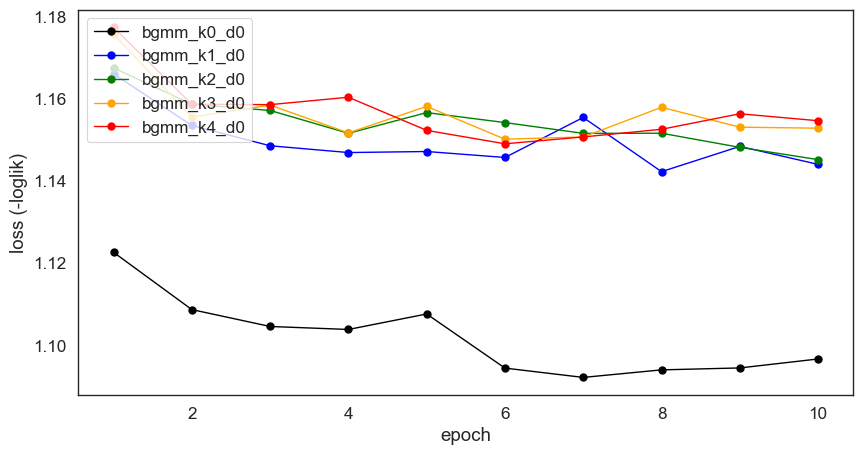

In [534]:
plt.figure(figsize=(10,5))

linecolors = {"0" : "black",
              "1" : "blue",
              "2" : "green",
              "3" : "orange",
              "4" : "red",
              "5" : "black",
              "6" : "blue",
              "7" : "green",
              "8" : "orange",
              "9" : "red"}

linestyles = {"bgmm" : "solid",
             "b2gmm" : "dashed",
             "gaussian" : "solid"}

markerstyles = {"0" : "o",
                "0.2" : "x",
                "0.3" : "^",
                "0.4" : ">"}

style_dict = {"linestyles" : linestyles,
             "linecolors" : linecolors}

for a in df.likelihood_fn.unique():
    for b in df.k.unique():
        for d in df.dropout_rate.unique(): 
            c = df[(df.likelihood_fn == a) & (df.k == b) & (df.dropout_rate == d)].copy()
            plt.plot(c.epoch, 
                     c.valid_loss, 
                     label=f'{a}_k{b}_d{d}', 
                     linestyle=linestyles[a],
                     color = linecolors[str(b)],
                     marker = markerstyles[str(d)],
                     linewidth = 1,
                     markersize = 5
                    )

plt.legend(loc='upper left')
#plt.xlim([0,20])
plt.xlabel('epoch')
plt.ylabel('loss (-loglik)')
plt.show()

### Sample from 2-Gamma mixture model and plot

In [ ]:
# %%time
# k = 1
# bins = 1000
# hist_max = 50
# r = np.random.randint(outputs.shape[0], size=k)
# print(r)
# dist = gmm_fn(pi=outputs[r,0],
#             alpha1=outputs[r,1],
#             alpha2=outputs[r,2],
#             beta1=outputs[r,3],
#             beta2=outputs[r,4],
#             q=outputs[r,5],
#             )

# plt.figure(figsize=(15,5))
# plt.plot(np.linspace(0,hist_max,bins),(torch.histc(dist.sample([1000000]), bins=bins, min=0, max=hist_max)))
# plt.plot(dist.mean,np.zeros(k),'or')
# plt.plot(test_tensor_y[r],np.zeros(k),'xk',ms=10)
# plt.show()

### Sample from Bernoulli-Gamma mixture model

In [118]:
interval=5

flag = 0
if flag:

    while True:

        x = np.linspace (0, 100, 200) 
        r = np.random.randint(len(inputs))
        print(r)

        pi = outputs[r,0]
        a = outputs[r,1]
        rate = outputs[r,2]

        y1 = stats.gamma.cdf(x, a=a, scale=1/rate) #a is alpha, loc is beta???

        mu = stats.gamma.mean(a=a, scale=1/rate)
        median = stats.gamma.median(a=a, scale=1/rate)
        mixture_median = stats.gamma.ppf((0.5 - pi) / (1 - pi), a=a, scale=1/rate) if pi < 0.5 else 0
        mixture_mean = (1-pi) * mu

        print("mean: %.2f" % mu)
        print("median: %.2f" % median)
        print("mixture median: %.2f" % mixture_median)
        print("mixture mean: %.2f" % mixture_mean)

        modelled = inputs[r,0]*x_std[0] + x_mean[0]
        observed = tensor_y[r,0]

        if modelled > 0:

            #mu = a/rate if pi<0.5 else 0

            plt.plot(0,pi,"oy", label="pi = %.2f" % pi)

            plt.plot(mu, 0, "or", mfc="white", label="mu = %.2f" % mu)
            plt.plot(median, 0, "xr", label="median = %.2f" % median)  
            plt.plot(mixture_median, 0, "ok", mfc="white", label="mixture median = %.2f" % mixture_median)  
            plt.plot(mixture_mean, 0, "^k", label="mixture median = %.2f" % mixture_mean)  

            plt.plot(modelled, 0, "x", label="WRF = %.2f" % modelled)

            plt.plot(observed, 0, "xg", label="observed = %.2f" % observed)
            plt.plot(x, pi + (1-pi)*y1, "y-", label=(r'$\alpha=%.2f, \beta=%.2f$') % (a, rate))

            plt.ylim([-0.05,1])
            plt.xlim([-0.2, max([1,modelled,observed,mu])*1.20])
            plt.legend(loc="upper right")
            plt.show()

            time.sleep(interval)

        else:
            pass

        clear_output(wait=True)

### Plot time series of predictions

In [102]:
p=0.05
multirun=True

if multirun:
    likelihood_fn = 'bgmm'
    st_test = predictions[likelihood_fn]['k_all']
else:
    likelihood_fn = model.likelihood

Length of clipped dataframe: 365


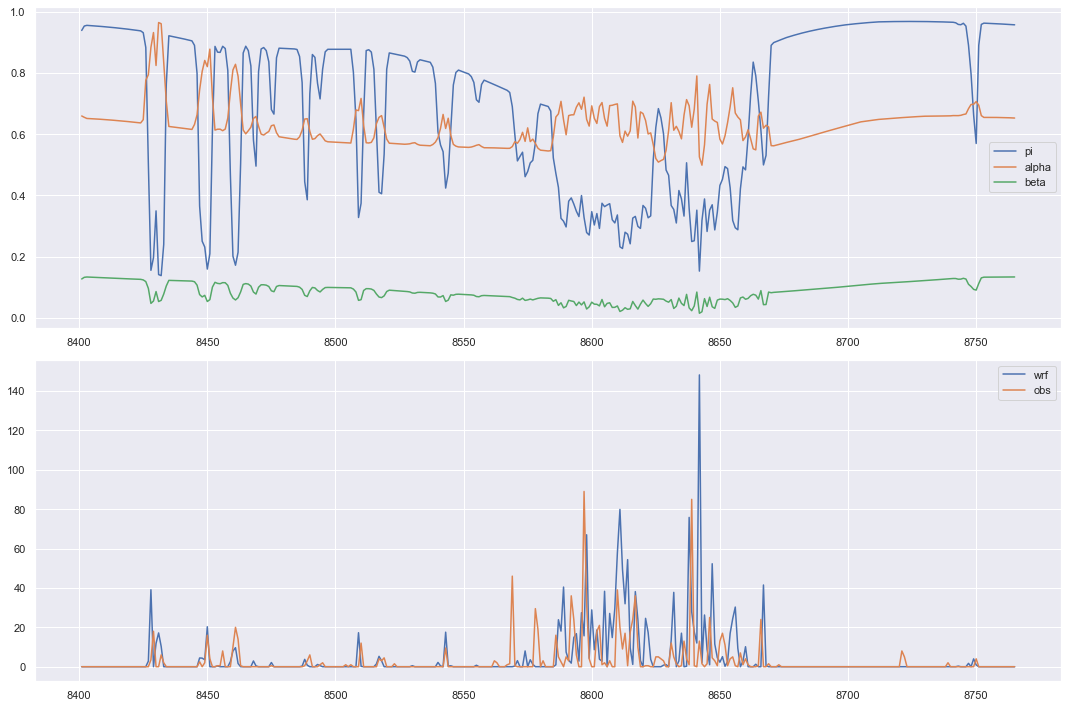

In [418]:
df = st_test[st_test['Station']=='Pandoh']
df = clip_time_period(df,'2003-01-01','2003-12-31')

fig,[ax1,ax2] = plt.subplots(2,1,figsize=(15,10))
ax1.plot(df['pi'],label='pi')
ax1.plot(df['alpha'],label='alpha')
ax1.plot(df['beta'],label='beta')
ax1.legend()
ax2.plot(df['wrf_prcp'],label='wrf')
ax2.plot(df['Prec'],label='obs')
ax2.legend()
plt.tight_layout()
plt.show()

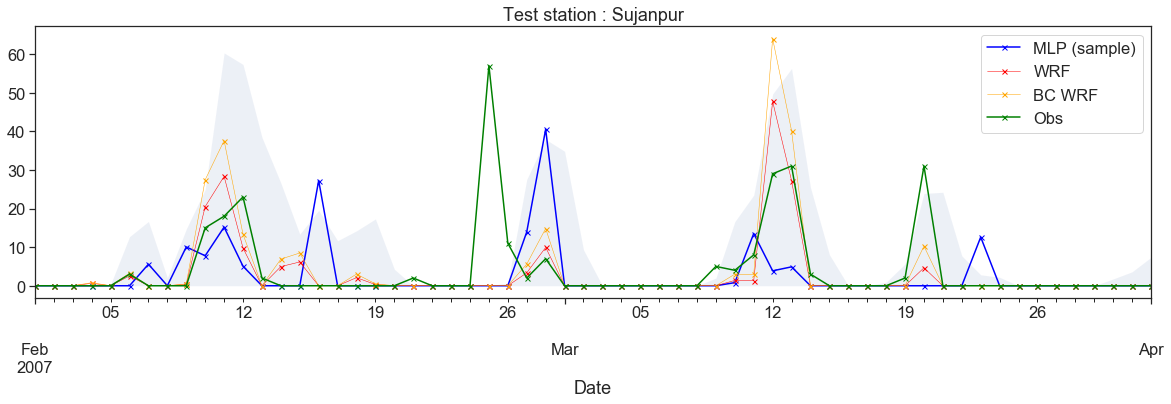

In [105]:
st_names_test = st_test['Station'].unique()

r = np.random.randint(len(st_names_test))
rand_test_st = st_names_test[r]
st_test_r = st_test[st_test['Station']==rand_test_st].copy()

xmin = "2007-02-01"
xmax = "2007-04-01" 

with sns.plotting_context("notebook", font_scale=1.5):
    plot_timeseries(st_test_r, 
                    likelihood_fn,
                    figsize=(20,5),
                    xmin = xmin,
                    xmax = xmax,
                    show_mean=False,
                    show_median=False, 
                    show_median_gamma=False,
                    show_confidence=True,
                    show_sample=True,
                    complete_title=False
                )

#plt.savefig(f"exports/March2021/tiemseries_{rand_test_st}_{xmin}_{xmax}.png")

### Print summary of results

In [ ]:
print_summary_of_results(st_test, likelihood_fn, alldays=True, drydays=True, wetdays=True, wet_threshold=50)

In [ ]:
day_filter = 'alldays'
p_threshold = 50

if day_filter=='drydays':
    st_test_summary = st_test[st_test['Prec']==0].groupby('Station').mean()
elif day_filter=='wetdays':
    st_test_summary = st_test[st_test['Prec']>=p_threshold].groupby('Station').mean()
elif day_filter=='alldays':
    st_test_summary = st_test.groupby('Station').mean()

#st_test_summary.drop(columns=['Altitude (m)', 'Prec', 'model_precipitation', 'doy', 'doy_cos', 'doy_sin'], inplace=True)

st_test_summary['se_mlp_ratio'] = 1 - st_test_summary['se_mlp']/st_test_summary['se_wrf']
st_test_summary['se_mlp_median_ratio'] = 1 - st_test_summary['se_mlp_median']/st_test_summary['se_wrf']
st_test_summary['se_mlp_median_gamma_ratio'] = 1 - st_test_summary['se_mlp_median_gamma']/st_test_summary['se_wrf']
st_test_summary['se_reg_ratio'] = 1 - st_test_summary['se_bcp']/st_test_summary['se_wrf']

In [ ]:
plt.figure(figsize=(8,8))
plt.style.use('seaborn-dark-palette')
plt.plot(st_test_summary['Z'],st_test_summary['se_mlp_ratio'],'og', label='$\mu$ - Neural Network (Bernoully Gamma mixture model)')
plt.plot(st_test_summary['Z'],st_test_summary['se_mlp_median_ratio'],'xb', label='$median$ - Neural Network (Bernoully Gamma mixture model)')
plt.plot(st_test_summary['Z'],st_test_summary['se_mlp_median_gamma_ratio'],'>k', label='$median$ $\Gamma$ - Neural Network (Bernoully Gamma mixture model)')

plt.plot(st_test_summary['Z'],st_test_summary['se_reg_ratio'],'or', label='Bannister et al. (2019)')

plt.xlabel("Elevation (masl)")
plt.ylabel("MSE reduction ratio")
plt.ylim([-1, 1])
plt.legend()
#plt.savefig(f"exports/MSE_plot_{day_filter}.png")
plt.show()

In [ ]:
"""plt.figure(figsize=(10,10))

plt.plot(st_test_r['Prec'], st_test_r['se_mlp'],'o',ms=4,label="MLP")
plt.plot(st_test_r['Prec'], st_test_r['se_wrf'],'x',ms=4,label="WRF")

plt.legend()

#plt.ylim([-0,20000])
plt.show()""";

In [90]:
path = '../../PhD/gis/exports/beas_watershed.shp'
beas_watershed = geopandas.read_file(path)

path = '../../PhD/gis/exports/sutlej_watershed.shp'
sutlej_watershed = geopandas.read_file(path)

In [88]:
stations_df_train = st[st['Station'].isin(st_names_dict['train'])].groupby(['Station']).mean()
stations_df_train = stations_df_train[['X','Y']]

stations_df_val = st[st['Station'].isin(st_names_dict['val'])].groupby(['Station']).mean()
stations_df_val = stations_df_val[['X','Y']]

#gdf = build_geodataframe(st_test_summary, x='X', y='Y')
gdf = build_geodataframe(st_test_annual_totals, x='X', y='Y')

#gdf_train = build_geodataframe(stations_df_train, x='X', y='Y')
#gdf_val = build_geodataframe(stations_df_val, x='X', y='Y')

NameError: name 'st_test_annual_totals' is not defined

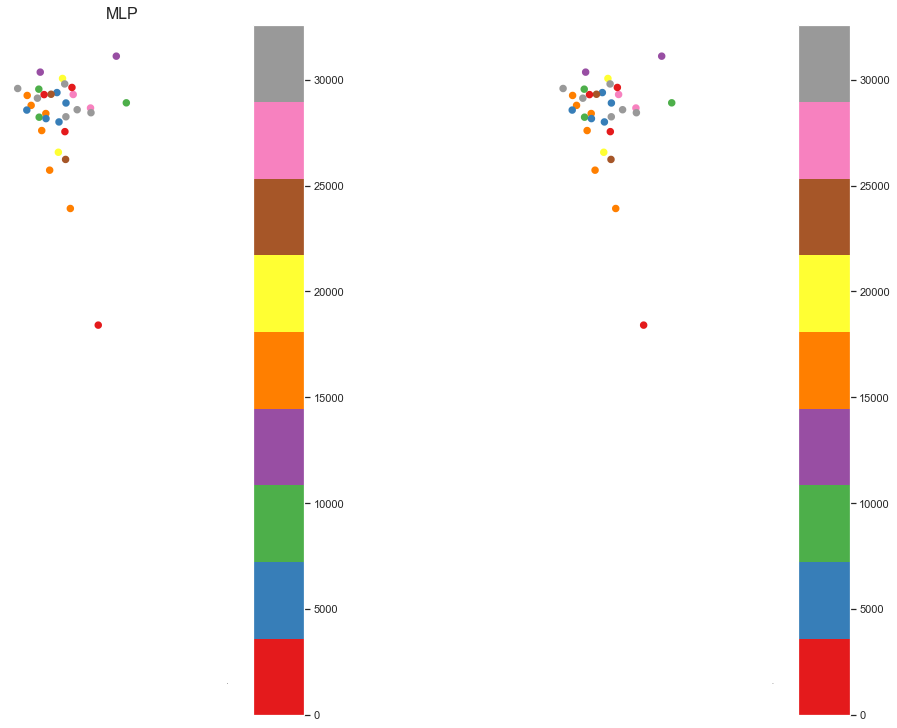

In [272]:
fig, axes = plt.subplots(1, 2, figsize=(15,10), constrained_layout=True)
#color_map = plt.cm.get_cmap('seismic').reversed()
margin = 0.25

for i, ax in enumerate(axes):
    gdf.plot(ax=ax, column='k_fold', legend=True, cmap='Set1', markersize=20, marker="o", linewidth=3)
    beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    #if i==len(axes)-1:
    #    plt.colorbar(plt.cm.ScalarMappable(cmap='Set1'), ax=ax, shrink=0.6)
    #ax.set_xlim(gdf.X.min() - margin*(gdf.X.max() - gdf.X.min()), gdf.X.max() + margin*(gdf.X.max() - gdf.X.min()))
    #ax.set_ylim(gdf.Y.min() - margin*(gdf.Y.max() - gdf.Y.min()), gdf.Y.max() + margin*(gdf.Y.max() - gdf.Y.min()))
    #ax.set_ylabel(" ")
    #ax.set_xlabel(" ")
    ax.set_axis_off()
    ax.set_aspect(1)

#axes[0].scatter(gdf.X, gdf.Y, c=gdf.se_mlp_ratio, cmap=color_map)
#gdf.plot(ax=axes[0], column='se_mlp_ratio',legend=True, edgecolor = 'white',  cmap=color_map,  markersize=100, vmin=-1, vmax=1)
axes[0].set_title('MLP', fontsize=16)
#gdf.plot(ax=axes[1], column='se_reg_ratio',legend=True, edgecolor = 'white', cmap=color_map,  markersize=100, vmin=-1, vmax=1)
#axes[1].set_title('Bannister et al. (2019)', fontsize=16)

#plt.legend()
#plt.tight_layout()
plt.show()

#plt.savefig(likelihood_fn+'.png');

In [314]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import AxesGrid
# import numpy as np
# plt.style.use('seaborn-dark-palette')

# title = ['$\mu$ Neural Network', '$median$ Neural Network', '$median$ $\Gamma$ Neural Network', 'Bannister et al. (2019)']
# var = ['se_mlp_ratio', 'se_mlp_median_ratio', 'se_mlp_median_gamma_ratio', 'se_reg_ratio']

# fig = plt.figure(figsize=(20, 20))

# color_map = plt.cm.get_cmap('seismic').reversed()

# grid = AxesGrid(fig, 111,
#                 nrows_ncols=(2, 2),
#                 #aspect=False,
#                 axes_pad=0,
#                 cbar_mode='single',
#                 cbar_location='right',
#                 cbar_pad=0.05,
#                 cbar_size="2.5%"
#                 )

# for i, ax in enumerate(grid):
#     ax.set_axis_off()
#     ax.set_yticks([])
#     ax.set_xticks([])
    
#     #ax.set_xlim(gdf.X.min() - margin*(gdf.X.max() - gdf.X.min()), gdf.X.max() + margin*(gdf.X.max() - gdf.X.min()))
#     #ax.set_ylim(gdf.Y.min() - margin*(gdf.Y.max() - gdf.Y.min()), gdf.Y.max() + margin*(gdf.Y.max() - gdf.Y.min()))
    
#     beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
#     sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    
#     if i==0:
#         pass
#         #gdf_train.plot(ax=ax, markersize=15, color='green')
#         #gdf_val.plot(ax=ax, markersize=15, color='orange')
    
#     sc = ax.scatter(gdf.X, gdf.Y, 
#                     c=gdf['k_fold'],#[var[i]], 
#                     s=100, marker='p', cmap=color_map, vmin=-1, vmax=1, edgecolor='k')
#     ax.set_title(title[i], fontsize=15)
    
# # when cbar_mode is 'single', for ax in grid, ax.cax = grid.cbar_axes[0]
# cbar = grid.cbar_axes[0].colorbar(sc)
# cbar.ax.set_yticks([-1,0,1])
# cbar.ax.tick_params(labelsize=15)
# #plt.savefig(f'exports/{likelihood_fn}_{np.random.randint(1000)}.png')
# plt.show()

In [282]:
# fig, ax = plt.subplots(1, 1, figsize=(10,10))
# gdf.plot(ax=ax, column='k_fold', legend=False, cmap='Set1', markersize=20, marker="o", linewidth=3)
# beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
# sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
# ax.set_axis_off()
# plt.savefig(f'exports/k_fold_{likelihood_fn}_{np.random.randint(1000)}.png')
# plt.show()

NameError: name 'map_results' is not defined

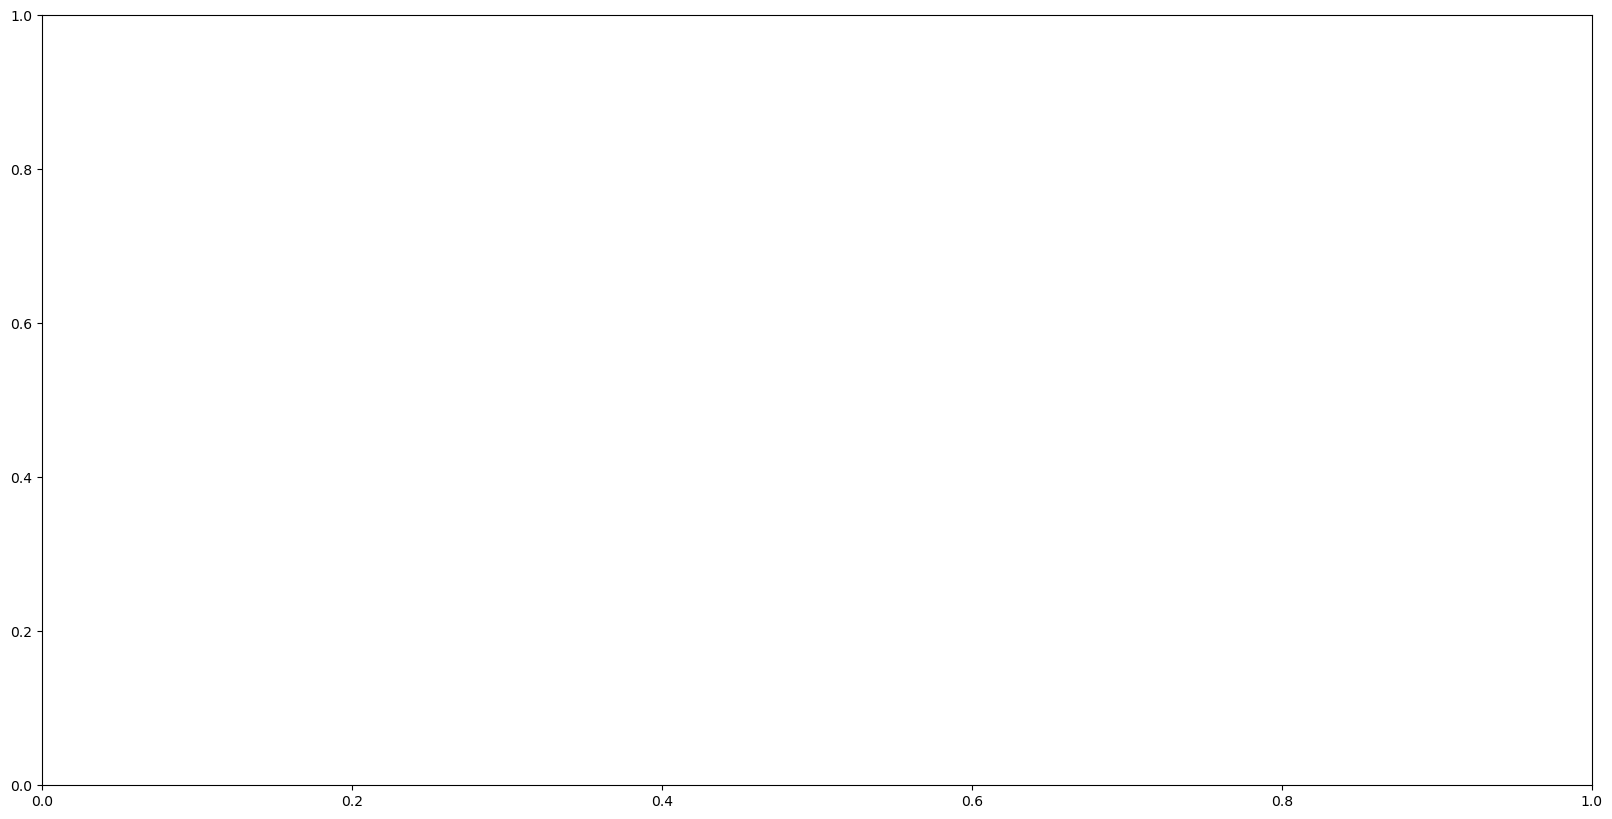

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x=map_results['X'],y=map_results['Y'],c=map_results['Z'], cmap='Blues', marker='s')
beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=1)
sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=1)
ax.set_yticks([]), ax.set_xticks([])
ax.set_frame_on(False)
#     ax.scatter(x=st.X, y=st.Y, s=5)
#     scatter = ax.scatter(x=st_test.X, y=st_test.Y, c=st_test['k_fold'],cmap='Paired',s=50, marker='p')
    
#     legend1 = ax.legend(*scatter.legend_elements(),loc="lower left", title="CV class")
#     ax.add_artist(legend1)
    
plt.show()
    #plt.tight_layout()